In [1]:


import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from sklearn.metrics import confusion_matrix
# import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
# from torchvision.transforms import Compose
from typing import Tuple, Dict

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:


#We define the dataset to load the adversarial results
class AdversarialDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        """
        Args:
            data_dict (dict): Dictionary containing adversarial data.
            transform (callable, optional): Optional transform to be applied on the examples.
        """
        self.data_dict = data_dict
        self.transform = transform

    def __len__(self):
        return len(self.data_dict["real_labels"])

    def __getitem__(self, idx):
        sample = {key: value[idx] for key, value in self.data_dict.items()}
        if self.transform:
            sample["examples"] = self.transform(sample["examples"])
        return sample

def Create_data_loader(batch_size=128)-> torch.utils.data.DataLoader:

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    testset = torchvision.datasets.CIFAR10(
        root='./data/01_raw', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return testloader


def resize_pad(image, ratio=0.8):
    """
    Resizes and pads an image with zeros to match the original size.

    Args:
        image (numpy.ndarray): The input image to resize and pad.
        ratio (float): The ratio to resize the image by (default 0.8).

    Returns:
        torch.Tensor: The resized and padded image.
    """
    original = image.numpy().transpose((1, 2, 0))
    old_size = original.shape[:2]
    new_size = int(old_size[0] * ratio)
    img = cv2.resize(original, (new_size, new_size))
    max_y = old_size[0] - new_size
    max_x = old_size[1] - new_size
    start_y = np.random.randint(0, max_y)
    start_x = np.random.randint(0, max_x)
    pad = np.zeros_like(original)
    pad[start_y:start_y + new_size, start_x:start_x + new_size] = img
    pad = cv2.flip(pad, 1)
    return torch.from_numpy(pad.transpose((2, 0, 1))).float()

def random_distortion(h, w, d, delta):
    """
    Returns distorted coordinates
    """
    nw = w // d
    nh = h // d
    distorted_coords = torch.zeros(nh+1, nw+1, 2)
    
    for m in range(nw+1):
        for n in range(nh+1):
            dx = (torch.rand(1) * 2 - 1) * delta  
            dy = (torch.rand(1) * 2 - 1) * delta 
            x = m * d + dx
            y = n * d + dy
            distorted_coords[n, m, 0] = x
            distorted_coords[n, m, 1] = y
            
    return distorted_coords


def image_distortion(img, d=4, delta=0.5):
    """
    Apply distortion to a given image.
    img: a tensor of shape (C, H, W)
    d: size of the grid
    delta: distortion limit
    """
    C, H, W = img.shape
    nw = W // d
    nh = H // d
    distorted_coords = random_distortion(H, W, d, delta)
    distorted_image = torch.zeros_like(img)
    
    for m in range(nw+1):
        for n in range(nh+1):
            src_x = m * d
            src_y = n * d
            dest_x = int(distorted_coords[n, m, 0].item())
            dest_y = int(distorted_coords[n, m, 1].item())
            for i in range(d+1):
                for j in range(d+1):
                    if src_y + j < H and src_x + i < W and dest_y + j < H and dest_x + i < W:
                        distorted_image[:, dest_y + j, dest_x + i] = img[:, src_y + j, src_x + i]
                        
    return distorted_image
# Here we define the transformations to be used in the dataloader
class ResizePadTransform:
    def __init__(self, ratio=0.8):
        self.ratio = ratio

    def __call__(self, image):
        return resize_pad(image, ratio=self.ratio)
class DistortTransform:
    def __init__(self, d=4, delta=0.5):
        self.d = d
        self.delta = delta
        
    def __call__(self, img):
        return image_distortion(img, self.d, self.delta)



def init_model(model:nn.Module)->torch.nn.Module:
    # Move model to GPU if available
    model = model.to(device)
    if device == 'cuda':
        model= torch.nn.DataParallel(model)
        cudnn.benchmark = True
    return model

def Padding_defense(dataset: Dict, params:Dict) -> torch.utils.data.DataLoader:
    transform_fn = transforms.Compose([
        ResizePadTransform(ratio = params["padding_ratio"]),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    dataset = AdversarialDataset(dataset, transform=transform_fn)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
    return dataloader

def Distort_defense(dataset: Dict, params:Dict) -> torch.utils.data.DataLoader:
    transform_fn = transforms.Compose([
        DistortTransform(d = params["window_size"], delta=params["delta"]),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    dataset = AdversarialDataset(dataset, transform=transform_fn)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
    return dataloader

def Padding_Distort_defense(dataset: Dict, params:Dict) -> torch.utils.data.DataLoader:
    transform_fn = transforms.Compose([
        DistortTransform(d=params["window_size"], delta=params["delta"]),
        ResizePadTransform(ratio=params["padding_ratio"]),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    dataset = AdversarialDataset(dataset, transform=transform_fn)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
    return dataloader


def Report(dataloader:torch.utils.data.DataLoader,model:nn.Module):
    model_classifier = init_model(model)
    model_classifier.eval()
    correct_defense = 0
    correct_model = 0
    correct_adversarial = 0
    total = 0
    confidence_defense = []
    true_labels = []
    model_predictions = []
    adversarial_predictions = []
    defense_predictions = []
    for batch in dataloader:
        images, real_labels = batch["examples"], batch["real_labels"]
        model_labels, adversarial_labels = batch["model_labels"], batch["adversarial_labels"]
    
        images, real_labels = images.to(device), real_labels.to(device)
        model_labels, adversarial_labels = model_labels.to(device), adversarial_labels.to(device)
        with torch.no_grad():
            outputs = model_classifier(images)
            _, predicted = torch.max(outputs.data, 1)
            confidence_defense.extend(F.softmax(outputs, dim=1).max(dim=1)[0].cpu().numpy())
            total += real_labels.size(0)
            correct_defense += (predicted == real_labels).sum().item()
            correct_model += (model_labels == real_labels).sum().item()
            correct_adversarial += (adversarial_labels == real_labels).sum().item()
            true_labels.extend(real_labels.cpu().numpy())
            model_predictions.extend(model_labels.cpu().numpy())
            adversarial_predictions.extend(adversarial_labels.cpu().numpy())
            defense_predictions.extend(predicted.cpu().numpy())

    original_accuracy = correct_model *100 /total
    adversarial_accuracy = correct_adversarial *100 /total
    defense_accuracy = correct_defense *100 /total
    return {"Accuracy":original_accuracy, "Adversarial_accuracy":adversarial_accuracy,"Defense_accuracy":defense_accuracy}

# Testing Padding Defense

In [8]:
catalog.load("params:Parameters_defenses")

[10/26/23 17:39:20] INFO     Loading data from 'params:Parameters_defenses' (MemoryDataset)...  ]8;id=825992;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=518341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\


{
    'Classes': [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ],
    'Resnet_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_x_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_y_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9}
}

In [12]:

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
parameters={'Resnet_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_x_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_y_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9}}
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    for attack in attacks:
        adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
        dataloader = Padding_defense(adver,parameters[f"{model_ref}"])
        metrics = Report(dataloader,model)
        print(f"{model_ref} with attack: {attack}")
        print(metrics)

[10/26/23 18:05:32] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=632936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=21398;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[10/26/23 18:05:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=795855;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=637023;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 76.78}


[10/26/23 18:05:35] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=397578;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=971755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 78.09}


[10/26/23 18:05:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=810861;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=25158;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 77.02}


[10/26/23 18:05:41] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=62176;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=44203;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 77.26}


[10/26/23 18:05:43] INFO     Loading data from 'Regnet_x_model' (PytorchDatasetModel)...        ]8;id=621469;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46771;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[10/26/23 18:05:44] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=708654;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=568591;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 75.47}


[10/26/23 18:05:47] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=573776;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=65652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 75.51}


[10/26/23 18:05:51] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=136453;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=110538;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 74.46}


[10/26/23 18:05:54] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=545733;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=900064;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 75.29}


[10/26/23 18:05:58] INFO     Loading data from 'Regnet_y_model' (PytorchDatasetModel)...        ]8;id=300764;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=155266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=877914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=512606;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 76.21}


[10/26/23 18:06:01] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=470090;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=557940;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 78.09}


[10/26/23 18:06:03] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=366389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224570;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 76.99}


[10/26/23 18:06:06] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=362226;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=341604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 77.3}


In [13]:

ratios = [i/10.0 for i in range(2, 10)]

results = {}

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    results[model_ref] = {}
    for attack in attacks:
        defenses_accuracies = []
        for ratio in ratios:

            parameters={'Resnet_model': {'padding_ratio': ratio},
                    'Regnet_x_model': {'padding_ratio': ratio},
                    'Regnet_y_model': {'padding_ratio': ratio}}
            adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
            dataloader = Padding_defense(adver,parameters[f"{model_ref}"])
            metrics = Report(dataloader,model)
            print(f"{model_ref} with attack: {attack}")
            print(metrics)
            defenses_accuracies.append(metrics['Defense_accuracy'])
        results[model_ref][attack] = defenses_accuracies


[10/26/23 18:27:11] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=324001;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=252707;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=844985;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=82341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 11.72}


[10/26/23 18:27:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=739507;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224785;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 13.51}


[10/26/23 18:27:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=323984;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=623316;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 18.72}


[10/26/23 18:27:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=936052;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=908732;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 27.75}


[10/26/23 18:27:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=207608;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659747;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 39.82}


[10/26/23 18:27:24] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=139812;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 55.21}


[10/26/23 18:27:27] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=109704;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=497950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.66}


[10/26/23 18:27:30] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=172567;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=441442;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 76.59}


[10/26/23 18:27:33] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=214612;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=129744;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 11.48}


[10/26/23 18:27:35] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=213478;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=944907;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 13.59}


[10/26/23 18:27:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=988161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=910369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 17.97}


[10/26/23 18:27:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=161162;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=981993;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 28.19}


[10/26/23 18:27:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=236876;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=240711;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 40.92}


[10/26/23 18:27:46] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=114114;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=285356;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 57.33}


[10/26/23 18:27:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=886496;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=379738;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.73}


[10/26/23 18:27:52] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=365077;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=11075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 78.16}


[10/26/23 18:27:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=724382;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=488900;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 11.46}


[10/26/23 18:27:57] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=945916;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=32789;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 13.48}


[10/26/23 18:28:00] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=335200;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751468;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 17.88}


[10/26/23 18:28:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=111457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 27.8}


[10/26/23 18:28:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=915750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=805523;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 40.19}


[10/26/23 18:28:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=215212;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880000;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 56.83}


[10/26/23 18:28:11] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=901097;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=862200;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.69}


[10/26/23 18:28:14] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=106446;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=267571;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 77.09}


[10/26/23 18:28:16] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=118137;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=591750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 11.72}


[10/26/23 18:28:19] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=349150;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=817201;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 13.28}


[10/26/23 18:28:22] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=937922;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=651105;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 17.84}


[10/26/23 18:28:25] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=135955;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=850526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 28.5}


[10/26/23 18:28:27] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=968517;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=526116;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 40.15}


[10/26/23 18:28:30] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=183928;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=282592;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 56.89}


[10/26/23 18:28:33] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=762261;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=200910;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 71.0}


[10/26/23 18:28:36] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=259087;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=818058;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 77.61}


[10/26/23 18:28:38] INFO     Loading data from 'Regnet_x_model' (PytorchDatasetModel)...        ]8;id=902453;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=187230;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=670646;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=369591;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 11.67}


[10/26/23 18:28:42] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=667324;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=953010;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 13.2}


[10/26/23 18:28:45] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=281045;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=245718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 16.75}


[10/26/23 18:28:49] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=981023;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=978073;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 28.11}


[10/26/23 18:28:53] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=67909;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=421647;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 41.94}


[10/26/23 18:28:56] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=511167;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948379;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 57.43}


[10/26/23 18:29:00] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=719847;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=595017;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 69.59}


[10/26/23 18:29:03] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=74311;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=143773;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 76.17}


[10/26/23 18:29:07] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=37960;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=279490;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 11.98}


[10/26/23 18:29:10] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=108591;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=425041;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 12.63}


[10/26/23 18:29:14] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=747456;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=138671;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 16.95}


[10/26/23 18:29:17] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=490569;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=392032;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 28.56}


[10/26/23 18:29:21] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=921396;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=891564;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 42.38}


[10/26/23 18:29:25] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=414644;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=781102;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 58.06}


[10/26/23 18:29:28] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=306144;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=338113;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.81}


[10/26/23 18:29:32] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=284349;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=642043;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 75.46}


[10/26/23 18:29:35] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=805626;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=597205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 12.01}


[10/26/23 18:29:39] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=925752;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=98713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 12.74}


[10/26/23 18:29:42] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=406404;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=28626;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 17.02}


[10/26/23 18:29:45] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=934088;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=14373;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 28.54}


[10/26/23 18:29:49] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=496563;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=770631;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 42.16}


[10/26/23 18:29:52] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=955851;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=18486;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 57.7}


[10/26/23 18:29:55] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=468738;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 68.33}


[10/26/23 18:29:58] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=540216;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12595;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 74.34}


[10/26/23 18:30:02] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=9275;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=531185;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 12.02}


[10/26/23 18:30:05] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=830301;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=16465;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 12.83}


[10/26/23 18:30:08] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=312950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=366148;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 16.79}


[10/26/23 18:30:12] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=464460;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=153758;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 28.35}


[10/26/23 18:30:15] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=712104;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=882139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 43.45}


[10/26/23 18:30:18] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=662394;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=762596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 57.78}


[10/26/23 18:30:21] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=752646;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=732856;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.23}


[10/26/23 18:30:25] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=596324;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=218389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 75.82}


[10/26/23 18:30:28] INFO     Loading data from 'Regnet_y_model' (PytorchDatasetModel)...        ]8;id=299808;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=696915;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=389480;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=615625;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 11.36}


[10/26/23 18:30:30] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=236260;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=851240;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 13.43}


[10/26/23 18:30:33] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=833022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=657115;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 17.91}


[10/26/23 18:30:36] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=727449;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=310415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 28.01}


[10/26/23 18:30:39] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=355256;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=177246;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 39.23}


[10/26/23 18:30:41] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=281551;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=89825;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 54.82}


[10/26/23 18:30:44] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=850898;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=302158;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.74}


[10/26/23 18:30:47] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=185140;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=657623;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 76.51}


[10/26/23 18:30:50] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=258168;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=33864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 11.93}


[10/26/23 18:30:52] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=15458;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=685687;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 13.64}


[10/26/23 18:30:55] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=722100;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=636330;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 18.11}


[10/26/23 18:30:58] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=590181;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=608194;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 28.12}


[10/26/23 18:31:00] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=658968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=380871;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 40.4}


[10/26/23 18:31:03] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=645088;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=568233;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 57.65}


[10/26/23 18:31:06] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=5361;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=119161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 71.7}


[10/26/23 18:31:09] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=311819;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=937071;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 78.42}


[10/26/23 18:31:12] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=637290;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=625485;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 11.7}


[10/26/23 18:31:14] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=100155;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=115680;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 12.95}


[10/26/23 18:31:17] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=290770;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401098;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 17.77}


[10/26/23 18:31:20] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=301986;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321999;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 28.64}


[10/26/23 18:31:22] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=653164;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=444422;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 39.96}


[10/26/23 18:31:25] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=410147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=301307;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 56.82}


[10/26/23 18:31:28] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=924980;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=892269;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.93}


[10/26/23 18:31:31] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=71161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=481374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 77.34}


[10/26/23 18:31:33] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=996276;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=264053;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 11.64}


[10/26/23 18:31:36] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=363711;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=129700;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 13.67}


[10/26/23 18:31:39] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=988238;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=703604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 17.74}


[10/26/23 18:31:42] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=646142;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=974795;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 28.34}


[10/26/23 18:31:44] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=487365;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=364500;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 40.4}


[10/26/23 18:31:47] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=121071;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=503161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 56.65}


[10/26/23 18:31:50] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=735729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=432630;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 71.3}


[10/26/23 18:31:53] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=911728;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=75661;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 77.53}


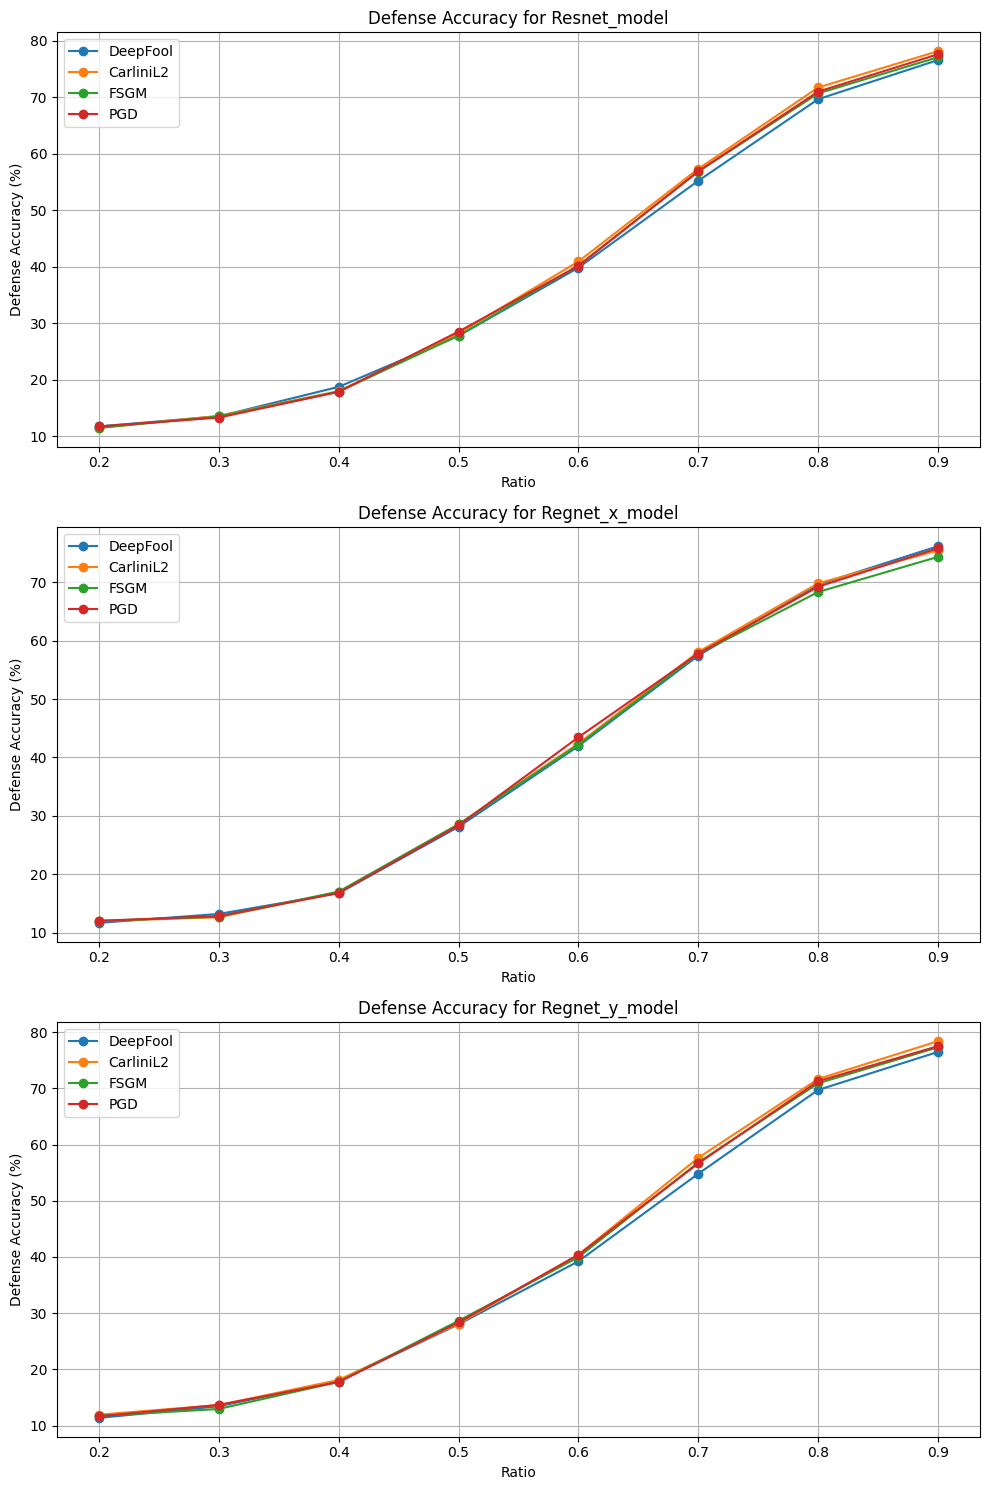

In [14]:

# Plot the results
fig, axs = plt.subplots(len(models), 1, figsize=(10, 15))
for i, model_ref in enumerate(models):
    for attack in attacks:
        axs[i].plot(ratios, results[model_ref][attack], label=attack, marker='o', linestyle='-')
    axs[i].set_xlabel('Ratio')
    axs[i].set_ylabel('Defense Accuracy (%)')
    axs[i].set_title(f'Defense Accuracy for {model_ref}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Para el caso del Padding tenemos que un padding del 90% mejora significativamente la presición para todos los modelos sobre todos los ataques
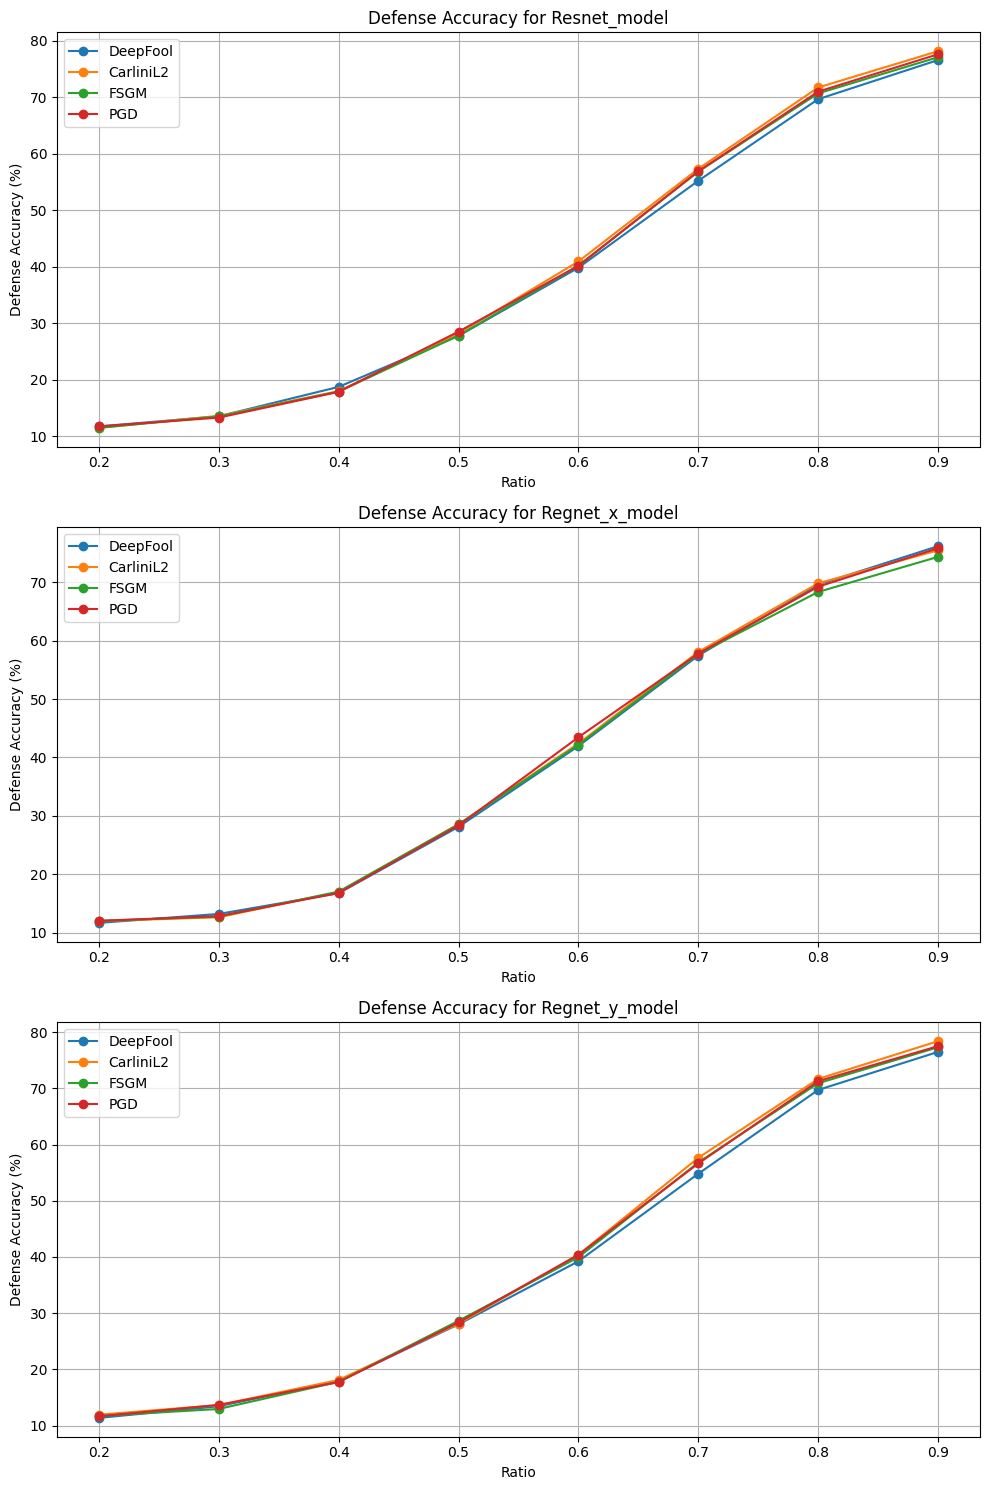

# Testing Distort

In [17]:

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
parameters={'Resnet_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_x_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_y_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9}}
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    for attack in attacks:
        adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
        dataloader = Distort_defense(adver,parameters[f"{model_ref}"])
        metrics = Report(dataloader,model)
        print(f"{model_ref} with attack: {attack}")
        print(metrics)

[10/26/23 18:47:01] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=468032;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=102099;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=263718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=424541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.69}


[10/26/23 18:47:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=62314;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=438549;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.52}


[10/26/23 18:48:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=138969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=844851;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.17}


[10/26/23 18:49:52] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=71992;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=733780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.83}


[10/26/23 18:50:49] INFO     Loading data from 'Regnet_x_model' (PytorchDatasetModel)...        ]8;id=99864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=541537;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=258339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 76.13}


[10/26/23 18:51:47] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=589328;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=767126;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.75}


[10/26/23 18:52:45] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=22799;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=302978;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.6}


[10/26/23 18:53:42] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=978665;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=616055;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.64}


[10/26/23 18:54:40] INFO     Loading data from 'Regnet_y_model' (PytorchDatasetModel)...        ]8;id=432487;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127255;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=883311;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=340776;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.49}


[10/26/23 18:55:37] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=538071;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=610154;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.54}


[10/26/23 18:56:35] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=547878;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=441620;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.48}


[10/26/23 18:57:32] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=467372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=447481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.78}


In [22]:

window_sizes = [4, 8, 16, 24 ,30]
deltas = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    results[model_ref] = {}
    for attack in attacks:
        # defenses_accuracies = []
        # for ratio in ratios:
        accuracies_matrix = np.zeros((len(deltas), len(window_sizes)))
        for idx_window, window in enumerate(window_sizes):
            for idx_delta, delta in enumerate(deltas):
                parameters = {
                        'Resnet_model': {'window_size': window, 'delta': delta},
                        'Regnet_x_model': {'window_size': window, 'delta': delta},
                        'Regnet_y_model': {'window_size': window, 'delta': delta}
                    }
                adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
                dataloader = Distort_defense(adver,parameters[f"{model_ref}"])
                metrics = Report(dataloader,model)
                print(f"{model_ref} with attack: {attack}, delta ={delta}, window = {window}")
                print(metrics)
                accuracies_matrix[idx_delta, idx_window] = metrics['Defense_accuracy']  
        results[model_ref][attack] = accuracies_matrix

[10/26/23 21:33:11] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=846842;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=181170;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=329468;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=100546;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.22}


[10/26/23 21:34:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=630969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=169026;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.38}


[10/26/23 21:35:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=357599;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=101145;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.92}


[10/26/23 21:37:18] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=129318;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.15}


[10/26/23 21:38:40] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=677556;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=405834;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.6}


[10/26/23 21:40:02] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=174916;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=377189;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.45}


[10/26/23 21:41:25] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=146425;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=348311;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.3}


[10/26/23 21:42:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=914522;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=392120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.61}


[10/26/23 21:43:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=860447;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=385826;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 72.92}


[10/26/23 21:44:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=962210;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=80369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.31}


[10/26/23 21:45:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=294214;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=541946;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.78}


[10/26/23 21:46:11] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=472851;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=408957;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.81}


[10/26/23 21:47:08] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=316975;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983376;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.8}


[10/26/23 21:47:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=840691;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=154628;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.27}


[10/26/23 21:48:44] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=228977;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=568915;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.17}


[10/26/23 21:49:32] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=321675;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=33412;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.28}


[10/26/23 21:50:20] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=918369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=241397;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.15}


[10/26/23 21:51:08] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=214288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64218;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.31}


[10/26/23 21:51:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=860632;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=165119;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 62.93}


[10/26/23 21:52:43] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=237070;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=707143;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.12}


[10/26/23 21:53:29] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=354679;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=213474;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.34}


[10/26/23 21:54:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=970324;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=708136;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.38}


[10/26/23 21:55:03] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=491196;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843487;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.57}


[10/26/23 21:55:50] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=512333;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=417499;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.62}


[10/26/23 21:56:37] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=580409;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=522639;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.61}


[10/26/23 21:57:24] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=249445;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=542726;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.51}


[10/26/23 21:58:11] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=859008;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170945;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.6}


[10/26/23 21:58:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=912956;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=924058;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.89}


[10/26/23 21:59:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=361620;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=475649;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.54}


[10/26/23 22:00:32] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=382762;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=173019;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.17}


[10/26/23 22:01:19] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=466022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=162418;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.17}


[10/26/23 22:02:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=884659;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346287;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.56}


[10/26/23 22:04:03] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=631402;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=628651;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.52}


[10/26/23 22:05:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=382601;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=405235;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.88}


[10/26/23 22:06:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=782686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64314;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.82}


[10/26/23 22:08:10] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=591895;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=686049;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 73.92}


[10/26/23 22:09:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=135248;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=386504;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.19}


[10/26/23 22:10:29] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=469487;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=473484;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.42}


[10/26/23 22:11:26] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=603467;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=532508;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.5}


[10/26/23 22:12:23] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=716777;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969594;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.58}


[10/26/23 22:13:21] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=480134;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=333565;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.64}


[10/26/23 22:14:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=82547;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=229491;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.4}


[10/26/23 22:15:15] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=220290;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=811957;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.88}


[10/26/23 22:16:03] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=507596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=622674;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.8}


[10/26/23 22:16:51] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=153099;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=344542;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.63}


[10/26/23 22:17:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=756859;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=912820;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.54}


[10/26/23 22:18:27] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=258071;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86137;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.46}


[10/26/23 22:19:15] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=588440;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=371038;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/26/23 22:20:03] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=140139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=625441;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.65}


[10/26/23 22:20:50] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=219284;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=619896;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.3}


[10/26/23 22:21:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=527790;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=728074;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.0}


[10/26/23 22:22:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=375738;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=612991;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.96}


[10/26/23 22:23:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=555489;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=60713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.63}


[10/26/23 22:23:57] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=23315;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=344123;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.85}


[10/26/23 22:24:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=525871;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=573833;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.86}


[10/26/23 22:25:31] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=46755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=94091;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.93}


[10/26/23 22:26:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=941883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=391932;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.63}


[10/26/23 22:27:05] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=375900;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=408581;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.86}


[10/26/23 22:27:52] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=151764;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=144151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.96}


[10/26/23 22:28:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=623247;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=234381;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.6}


[10/26/23 22:29:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=280139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=269332;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.1}


[10/26/23 22:30:49] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=272159;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=439589;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.46}


[10/26/23 22:32:11] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=696605;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=798798;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.8}


[10/26/23 22:33:34] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=527689;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.18}


[10/26/23 22:34:56] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=96308;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=805846;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.37}


[10/26/23 22:36:18] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=255894;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=319387;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.93}


[10/26/23 22:37:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=528540;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=769623;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.68}


[10/26/23 22:38:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=806438;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=769911;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.93}


[10/26/23 22:39:35] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=494313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=629340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.75}


[10/26/23 22:40:32] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=830526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=179338;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.17}


[10/26/23 22:41:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=844845;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=793705;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.02}


[10/26/23 22:42:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=955325;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=234602;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.28}


[10/26/23 22:43:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=950385;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=331564;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.66}


[10/26/23 22:44:12] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=184147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273647;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.74}


[10/26/23 22:45:00] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=710525;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659940;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.49}


[10/26/23 22:45:48] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=59261;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=643382;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.86}


[10/26/23 22:46:36] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=332846;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=721481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.12}


[10/26/23 22:47:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=587372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=622063;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.6}


[10/26/23 22:48:12] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=51716;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=634650;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.03}


[10/26/23 22:48:59] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=790420;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=781534;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.2}


[10/26/23 22:49:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=803691;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=621995;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.97}


[10/26/23 22:50:33] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=580486;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=475126;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.31}


[10/26/23 22:51:19] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=238100;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=344121;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.4}


[10/26/23 22:52:06] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=215249;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=980914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.12}


[10/26/23 22:52:53] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=990532;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528945;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.16}


[10/26/23 22:53:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=197755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=841008;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.09}


[10/26/23 22:54:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=246074;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=370262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.25}


[10/26/23 22:55:14] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=487933;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=466325;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.92}


[10/26/23 22:56:01] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=700712;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=764993;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.11}


[10/26/23 22:56:48] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=504219;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=455913;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.24}


[10/26/23 22:57:35] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=956656;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=544360;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.36}


[10/26/23 22:58:57] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=94579;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=773453;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.46}


[10/26/23 23:00:20] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=728639;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=424036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.13}


[10/26/23 23:01:42] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=866472;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=113969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.62}


[10/26/23 23:03:04] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=898034;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=959512;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.37}


[10/26/23 23:04:26] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=896264;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=543550;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.98}


[10/26/23 23:05:49] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=761036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=93613;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.17}


[10/26/23 23:06:46] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=532293;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=722955;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.42}


[10/26/23 23:07:43] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=229383;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=857184;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.82}


[10/26/23 23:08:40] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=53934;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=836194;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.37}


[10/26/23 23:09:37] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=435410;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975187;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.91}


[10/26/23 23:10:34] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=223377;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=613671;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.5}


[10/26/23 23:11:32] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=865764;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=327552;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.8}


[10/26/23 23:12:19] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=251463;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7499;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.52}


[10/26/23 23:13:07] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=156725;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=621831;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.83}


[10/26/23 23:13:56] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=79525;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=615898;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.95}


[10/26/23 23:14:44] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=297094;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=235519;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.66}


[10/26/23 23:15:32] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=650115;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=982746;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.2}


[10/26/23 23:16:20] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=937859;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=677182;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.57}


[10/26/23 23:17:06] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=949309;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=737230;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.75}


[10/26/23 23:17:53] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=830212;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=303692;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.05}


[10/26/23 23:18:40] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=103050;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=911917;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.58}


[10/26/23 23:19:27] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=189415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=44647;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.7}


[10/26/23 23:20:13] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=640851;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556726;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.8}


[10/26/23 23:21:00] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=594856;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=538018;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.65}


[10/26/23 23:21:47] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=644297;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=629278;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.61}


[10/26/23 23:22:34] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=474120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=139428;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.76}


[10/26/23 23:23:21] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=341253;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=878485;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.92}


[10/26/23 23:24:08] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=508107;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=269802;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.08}


[10/26/23 23:24:55] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=377048;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=572928;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.71}


[10/26/23 23:25:42] INFO     Loading data from 'Regnet_x_model' (PytorchDatasetModel)...        ]8;id=801539;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=812180;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=269824;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=436679;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.1, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.87}


[10/26/23 23:27:05] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=180840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=942564;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.3, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.48}


[10/26/23 23:28:28] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=189625;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=800416;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.5, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.62}


[10/26/23 23:29:51] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=898229;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=807911;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.7, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.73}


[10/26/23 23:31:14] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=105371;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=444902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.9, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.93}


[10/26/23 23:32:36] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=209362;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=353117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =1.0, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 73.8}


[10/26/23 23:33:59] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=758616;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=489327;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.1, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 76.05}


[10/26/23 23:34:57] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=603932;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=603714;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.3, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 75.64}


[10/26/23 23:35:55] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=463801;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=527806;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.5, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 76.04}


[10/26/23 23:36:52] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=169964;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291621;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.7, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 75.87}


[10/26/23 23:37:50] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=10926;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=925726;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.9, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 76.26}


[10/26/23 23:38:48] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=535531;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=446232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =1.0, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 75.5}


[10/26/23 23:39:45] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=921814;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=467591;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.1, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 70.51}


[10/26/23 23:40:34] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=864994;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=985402;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.3, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 71.16}


[10/26/23 23:41:23] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=499839;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=599737;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.5, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 71.71}


[10/26/23 23:42:11] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=517995;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=97775;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.7, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 70.31}


[10/26/23 23:43:00] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=431816;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=448931;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.9, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 70.74}


[10/26/23 23:43:48] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=138356;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=598896;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =1.0, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 70.73}


[10/26/23 23:44:37] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=188965;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=544794;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.1, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 67.07}


[10/26/23 23:45:24] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=246965;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=355046;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.3, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 66.91}


[10/26/23 23:46:11] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=498936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=257147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.5, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 67.07}


[10/26/23 23:46:58] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=487920;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=617417;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.7, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 66.58}


[10/26/23 23:47:46] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=121142;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=716325;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.9, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 66.91}


[10/26/23 23:48:33] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=451061;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46614;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =1.0, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 67.06}


[10/26/23 23:49:20] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=379834;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=226507;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.1, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 60.36}


[10/26/23 23:50:08] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=541825;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=976815;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.3, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 59.58}


[10/26/23 23:50:55] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=541805;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=373528;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.5, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 60.04}


[10/26/23 23:51:43] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=192390;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=334935;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.7, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 59.47}


[10/26/23 23:52:30] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=911907;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=369971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =0.9, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 59.97}


[10/26/23 23:53:18] INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=422002;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=378100;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool, delta =1.0, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 60.62}


[10/26/23 23:54:05] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=759631;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=683418;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.1, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.06}


[10/26/23 23:55:28] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=540408;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=328968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.3, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.04}


[10/26/23 23:56:51] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=565399;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=646564;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.5, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 73.67}


[10/26/23 23:58:14] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=296518;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=243706;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.7, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 73.99}


[10/26/23 23:59:36] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=396259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=908233;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.9, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 73.71}


[10/27/23 00:00:59] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=120780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=893749;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =1.0, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 73.64}


[10/27/23 00:02:22] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=300780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=754135;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.1, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.72}


[10/27/23 00:03:19] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=725121;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=215405;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.3, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.73}


[10/27/23 00:04:17] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=144264;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=485909;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.5, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.36}


[10/27/23 00:05:15] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=504852;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=230752;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.7, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.74}


[10/27/23 00:06:12] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=180009;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=334708;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.9, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.59}


[10/27/23 00:07:10] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=51242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=765422;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =1.0, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.66}


[10/27/23 00:08:08] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=194358;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=922617;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.1, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.67}


[10/27/23 00:08:56] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=769816;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=762162;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.3, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.25}


[10/27/23 00:09:45] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=288917;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=162482;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.5, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.76}


[10/27/23 00:10:33] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=940196;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=111719;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.7, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.45}


[10/27/23 00:11:22] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=94382;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=763266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.9, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.61}


[10/27/23 00:12:10] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=660491;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=345392;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =1.0, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 69.43}


[10/27/23 00:12:59] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=504278;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=433656;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.1, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 62.2}


[10/27/23 00:13:46] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=244683;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=650582;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.3, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 61.72}


[10/27/23 00:14:34] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=644927;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431863;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.5, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 62.14}


[10/27/23 00:15:21] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=126432;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528841;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.7, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 62.11}


[10/27/23 00:16:08] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=639945;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=16518;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.9, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 61.75}


[10/27/23 00:16:56] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=738830;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=372830;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =1.0, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 62.38}


[10/27/23 00:17:43] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=817138;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=899705;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.1, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 56.11}


[10/27/23 00:18:31] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=453883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=729959;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.3, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 56.4}


[10/27/23 00:19:18] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=440254;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=268534;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.5, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 56.67}


[10/27/23 00:20:05] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=940862;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=978649;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.7, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 55.77}


[10/27/23 00:20:53] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=110235;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=550358;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =0.9, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 56.38}


[10/27/23 00:21:40] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=664792;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=973982;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2, delta =1.0, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 56.28}


[10/27/23 00:22:28] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=934995;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=49301;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.1, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 72.05}


[10/27/23 00:23:50] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=485780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674336;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.3, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.93}


[10/27/23 00:25:13] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=570741;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=391146;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.5, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.7}


[10/27/23 00:26:36] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=193556;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=244109;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.7, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.74}


[10/27/23 00:27:58] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=308442;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=642724;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.9, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 72.12}


[10/27/23 00:29:20] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=995929;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674786;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =1.0, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 72.13}


[10/27/23 00:30:43] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=994827;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365715;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.1, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.49}


[10/27/23 00:31:40] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=531112;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=721551;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.3, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.87}


[10/27/23 00:32:38] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=9503;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=774110;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.5, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.43}


[10/27/23 00:33:35] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=169848;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=833306;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.7, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.88}


[10/27/23 00:34:33] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=785162;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=240340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.9, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.49}


[10/27/23 00:35:31] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=783305;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=952899;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =1.0, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.8}


[10/27/23 00:36:29] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=186762;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=582237;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.1, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 67.86}


[10/27/23 00:37:17] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=662540;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=685812;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.3, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 67.99}


[10/27/23 00:38:05] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=160965;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659933;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.5, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 67.38}


[10/27/23 00:38:54] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=525286;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=698925;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.7, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 67.57}


[10/27/23 00:39:43] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=708680;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=60539;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.9, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 67.18}


[10/27/23 00:40:31] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=950718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=596889;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =1.0, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 66.85}


[10/27/23 00:41:19] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=506021;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=248693;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.1, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.26}


[10/27/23 00:42:07] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=611305;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668317;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.3, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.35}


[10/27/23 00:42:54] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=861282;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=735906;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.5, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.25}


[10/27/23 00:43:41] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=78689;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=993758;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.7, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.2}


[10/27/23 00:44:28] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=339009;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668597;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.9, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.41}


[10/27/23 00:45:15] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=356247;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=223225;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =1.0, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 63.02}


[10/27/23 00:46:03] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=226210;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=127722;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.1, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 60.54}


[10/27/23 00:46:50] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=100971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=357796;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.3, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 61.05}


[10/27/23 00:47:37] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=479333;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291673;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.5, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 60.45}


[10/27/23 00:48:25] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=486771;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=328429;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.7, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 60.35}


[10/27/23 00:49:12] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=340831;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=376582;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =0.9, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 60.66}


[10/27/23 00:50:00] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=559248;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=734575;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM, delta =1.0, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 60.72}


[10/27/23 00:50:48] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=281288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=440099;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.1, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 72.7}


[10/27/23 00:52:10] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=34889;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=395465;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.3, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.2}


[10/27/23 00:53:33] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=241655;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=878844;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.5, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 72.95}


[10/27/23 00:54:56] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=819948;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=837922;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.7, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.25}


[10/27/23 00:56:19] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=844546;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=316918;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.9, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 72.74}


[10/27/23 00:57:41] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=561515;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=532021;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =1.0, window = 4
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 72.56}


[10/27/23 00:59:04] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=350545;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=154123;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.1, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.12}


[10/27/23 01:00:02] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=370278;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=862053;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.3, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.29}


[10/27/23 01:00:59] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=892938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=467438;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.5, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.07}


[10/27/23 01:01:57] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=241493;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=388322;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.7, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.24}


[10/27/23 01:02:55] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=238096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=818789;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.9, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.27}


[10/27/23 01:03:52] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=243703;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=36490;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =1.0, window = 8
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.16}


[10/27/23 01:04:50] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=530707;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=204824;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.1, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.69}


[10/27/23 01:05:39] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=852022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=37200;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.3, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.73}


[10/27/23 01:06:27] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=218786;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=187964;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.5, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.56}


[10/27/23 01:07:15] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=17749;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=611334;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.7, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.38}


[10/27/23 01:08:04] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=363862;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=662577;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.9, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 69.35}


[10/27/23 01:08:52] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=547527;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=220366;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =1.0, window = 16
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 68.99}


[10/27/23 01:09:41] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=120497;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=926738;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.1, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.45}


[10/27/23 01:10:28] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=533884;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=809862;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.3, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.34}


[10/27/23 01:11:15] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=802893;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276306;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.5, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.22}


[10/27/23 01:12:02] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=664033;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=583712;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.7, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.42}


[10/27/23 01:12:50] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=929273;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880761;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.9, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.09}


[10/27/23 01:13:37] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=840461;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=413098;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =1.0, window = 24
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 65.32}


[10/27/23 01:14:24] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=205470;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=603755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.1, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.62}


[10/27/23 01:15:12] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=57883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=10909;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.3, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.54}


[10/27/23 01:15:59] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=383678;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=670534;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.5, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.67}


[10/27/23 01:16:47] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=139622;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=395721;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.7, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.76}


[10/27/23 01:17:34] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=714512;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403030;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =0.9, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.71}


[10/27/23 01:18:22] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=205921;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=23480;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD, delta =1.0, window = 30
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 62.64}


[10/27/23 01:19:09] INFO     Loading data from 'Regnet_y_model' (PytorchDatasetModel)...        ]8;id=823580;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=909361;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=170751;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=414064;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.94}


[10/27/23 01:20:32] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=637195;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=449863;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.78}


[10/27/23 01:21:54] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=851288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321844;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.13}


[10/27/23 01:23:17] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=600482;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=724083;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.18}


[10/27/23 01:24:39] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=896092;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=778135;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.63}


[10/27/23 01:26:01] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=643723;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=247729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.18}


[10/27/23 01:27:24] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=975929;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843986;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.35}


[10/27/23 01:28:21] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=924383;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=416923;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.73}


[10/27/23 01:29:18] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=219132;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=285108;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.22}


[10/27/23 01:30:15] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=690733;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=687025;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.91}


[10/27/23 01:31:12] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=315181;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=3231;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.57}


[10/27/23 01:32:09] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=922973;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=471326;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.64}


[10/27/23 01:33:07] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=176604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=907171;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.96}


[10/27/23 01:33:55] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=248335;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=592895;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.75}


[10/27/23 01:34:43] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=569206;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=640228;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.3}


[10/27/23 01:35:31] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=155674;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=851113;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.65}


[10/27/23 01:36:19] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=823674;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403195;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.06}


[10/27/23 01:37:06] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=864575;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=56362;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.59}


[10/27/23 01:37:54] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=46998;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=758613;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 62.93}


[10/27/23 01:38:41] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=586126;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=159792;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.31}


[10/27/23 01:39:28] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=497424;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=87346;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.15}


[10/27/23 01:40:15] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=946598;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=698357;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.75}


[10/27/23 01:41:02] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=632792;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=507568;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.91}


[10/27/23 01:41:48] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=542265;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=83437;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.74}


[10/27/23 01:42:35] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=856147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224362;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.36}


[10/27/23 01:43:22] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=448784;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=618723;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.91}


[10/27/23 01:44:09] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=360645;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=302374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.77}


[10/27/23 01:44:56] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=562541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=892040;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.18}


[10/27/23 01:45:43] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=561469;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=802685;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.51}


[10/27/23 01:46:30] INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=911062;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=267295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.6}


[10/27/23 01:47:17] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=670968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=949916;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.33}


[10/27/23 01:48:39] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=359455;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=563204;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.0}


[10/27/23 01:50:02] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=678111;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=832819;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.05}


[10/27/23 01:51:24] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=341900;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170915;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.47}


[10/27/23 01:52:46] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=803352;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=497968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.52}


[10/27/23 01:54:08] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=256492;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=590704;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.44}


[10/27/23 01:55:30] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=925230;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=996353;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.66}


[10/27/23 01:56:28] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=61455;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=147218;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.57}


[10/27/23 01:57:25] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=981783;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=850533;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.13}


[10/27/23 01:58:22] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=41553;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.71}


[10/27/23 01:59:19] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=879823;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406306;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.14}


[10/27/23 02:00:16] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=416476;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=801917;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.41}


[10/27/23 02:01:13] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=451676;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=42698;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.69}


[10/27/23 02:02:02] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=222929;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=228126;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.76}


[10/27/23 02:02:50] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=633091;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=305101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.9}


[10/27/23 02:03:37] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=16259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=860885;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.38}


[10/27/23 02:04:25] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=231864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=316935;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.64}


[10/27/23 02:05:13] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=239465;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=57693;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 74.96}


[10/27/23 02:06:01] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=949036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=863975;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 71.84}


[10/27/23 02:06:48] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=715343;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=43399;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 72.1}


[10/27/23 02:07:35] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=481091;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=6502;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 71.95}


[10/27/23 02:08:22] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=350988;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=619022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 72.38}


[10/27/23 02:09:09] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=149380;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=571726;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 71.92}


[10/27/23 02:09:55] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=831479;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=130307;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 72.1}


[10/27/23 02:10:42] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=151924;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689100;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 68.99}


[10/27/23 02:11:29] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=418763;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=764836;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 69.01}


[10/27/23 02:12:16] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=199147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289159;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 68.88}


[10/27/23 02:13:03] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=251121;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406068;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 68.69}


[10/27/23 02:13:50] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=882988;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=562338;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 69.1}


[10/27/23 02:14:37] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=936457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=508936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 68.83}


[10/27/23 02:15:24] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=269946;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=890773;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.29}


[10/27/23 02:16:46] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=650250;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=722658;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.96}


[10/27/23 02:18:09] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=481780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=93249;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.64}


[10/27/23 02:19:31] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=793092;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=542217;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.26}


[10/27/23 02:20:54] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=375293;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=744295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.34}


[10/27/23 02:22:16] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=259349;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=974282;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.17}


[10/27/23 02:23:38] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=596161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=135544;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.0}


[10/27/23 02:24:35] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=654372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=557672;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.82}


[10/27/23 02:25:33] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=742242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=777266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.87}


[10/27/23 02:26:30] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=524810;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=443987;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.57}


[10/27/23 02:27:27] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=29945;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170770;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.93}


[10/27/23 02:28:24] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=629312;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=473375;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.08}


[10/27/23 02:29:21] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=569250;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=94186;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.76}


[10/27/23 02:30:09] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=591226;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=7348;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.45}


[10/27/23 02:30:57] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=37686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=262017;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.7}


[10/27/23 02:31:45] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=12826;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=766982;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.46}


[10/27/23 02:32:33] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=248037;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=387672;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.83}


[10/27/23 02:33:21] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=700535;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915937;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.38}


[10/27/23 02:34:09] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=926809;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=347438;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.1}


[10/27/23 02:34:56] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=195432;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=892514;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.1}


[10/27/23 02:35:43] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=779402;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12287;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.1}


[10/27/23 02:36:30] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=833760;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=999780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.36}


[10/27/23 02:37:16] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=428874;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=386136;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.08}


[10/27/23 02:38:03] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=638650;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=244232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.21}


[10/27/23 02:38:50] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=271854;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=572860;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.61}


[10/27/23 02:39:37] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=131578;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775309;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.13}


[10/27/23 02:40:24] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=730701;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=188034;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.16}


[10/27/23 02:41:11] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=704778;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=550375;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.95}


[10/27/23 02:41:58] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=177332;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=180637;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.19}


[10/27/23 02:42:45] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=479167;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.0}


[10/27/23 02:43:32] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=974208;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=188598;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.1, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.61}


[10/27/23 02:44:54] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=144984;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=452582;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.3, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.18}


[10/27/23 02:46:16] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=947805;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=990807;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.5, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.96}


[10/27/23 02:47:39] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=599052;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=95010;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.7, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.52}


[10/27/23 02:49:01] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=334270;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224622;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.9, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.56}


[10/27/23 02:50:23] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=586346;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=633765;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =1.0, window = 4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.35}


[10/27/23 02:51:46] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=376828;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=208262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.1, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.15}


[10/27/23 02:52:43] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=45985;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=169108;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.3, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.37}


[10/27/23 02:53:40] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=447104;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=831128;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.5, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.54}


[10/27/23 02:54:37] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=103710;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=921307;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.7, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.53}


[10/27/23 02:55:34] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=535684;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=889606;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.9, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.35}


[10/27/23 02:56:31] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=158864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=670286;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =1.0, window = 8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.26}


[10/27/23 02:57:29] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=391002;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=889584;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.1, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 74.6}


[10/27/23 02:58:17] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=593050;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.3, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.06}


[10/27/23 02:59:05] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=995730;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=70087;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.5, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.23}


[10/27/23 02:59:53] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=37411;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321623;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.7, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 74.9}


[10/27/23 03:00:41] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=1843;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=165147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.9, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 74.97}


[10/27/23 03:01:29] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=835805;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=105021;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =1.0, window = 16
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 74.92}


[10/27/23 03:02:17] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=700365;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=184329;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.1, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.31}


[10/27/23 03:03:04] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=573749;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8816;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.3, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.82}


[10/27/23 03:03:50] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=921305;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=205893;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.5, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.91}


[10/27/23 03:04:37] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=691133;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=917117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.7, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.42}


[10/27/23 03:05:24] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=518088;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=626765;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.9, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.49}


[10/27/23 03:06:11] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=300394;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=330516;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =1.0, window = 24
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 73.82}


[10/27/23 03:06:58] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=865377;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=901978;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.1, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.96}


[10/27/23 03:07:45] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=915231;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=563521;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.3, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.58}


[10/27/23 03:08:32] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=330932;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=507999;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.5, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.74}


[10/27/23 03:09:19] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=629846;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=454630;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.7, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.7}


[10/27/23 03:10:06] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=126779;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=518828;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =0.9, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.94}


[10/27/23 03:10:53] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=266616;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=430610;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD, delta =1.0, window = 30
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 72.7}


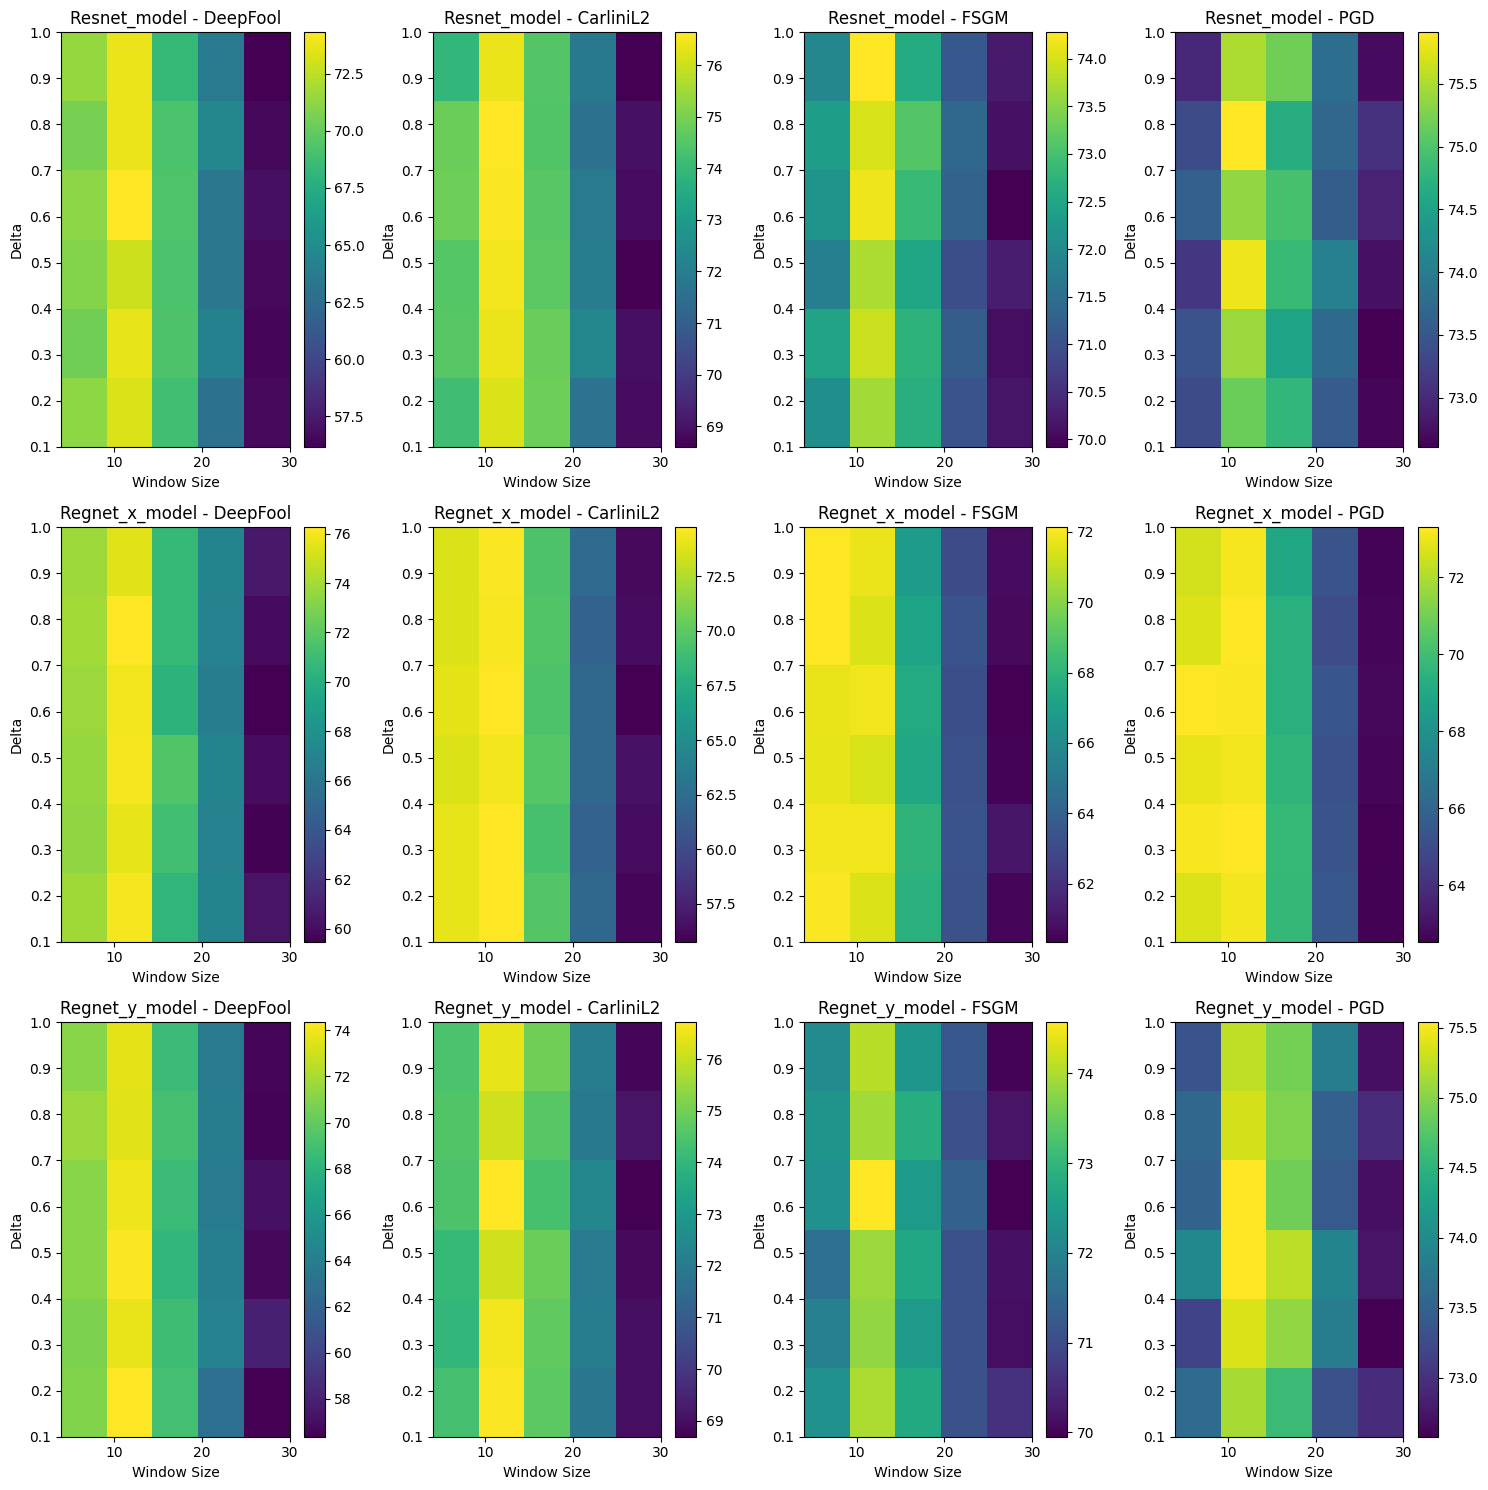

In [23]:
# Plot the results
fig, axs = plt.subplots(len(models), len(attacks), figsize=(15, 15))
for i, model_ref in enumerate(models):
    for j, attack in enumerate(attacks):
        cax = axs[i, j].imshow(results[model_ref][attack], cmap='viridis', aspect='auto', 
                              interpolation='nearest', origin='lower', 
                              extent=[window_sizes[0], window_sizes[-1], deltas[0], deltas[-1]])
        axs[i, j].set_xlabel('Window Size')
        axs[i, j].set_ylabel('Delta')
        axs[i, j].set_title(f'{model_ref} - {attack}')
        plt.colorbar(cax, ax=axs[i, j])

plt.tight_layout()
plt.show()

# Testing Distort + Padding

In [24]:

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
parameters={'Resnet_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_x_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9},
    'Regnet_y_model': {'window_size': 8, 'delta': 0.1, 'padding_ratio': 0.9}}
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    for attack in attacks:
        adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
        dataloader = Distort_defense(adver,parameters[f"{model_ref}"])
        metrics = Report(dataloader,model)
        print(f"{model_ref} with attack: {attack}")
        print(metrics)

[10/27/23 03:11:41] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=283592;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=83291;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=317697;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=927178;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.26}


[10/27/23 03:12:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=896795;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=743652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.76}


[10/27/23 03:13:35] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=108670;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=283105;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.79}


[10/27/23 03:14:33] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=33116;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=108714;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.96}


[10/27/23 03:15:30] INFO     Loading data from 'Regnet_x_model' (PytorchDatasetModel)...        ]8;id=560101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=573662;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_x_model_Adversarial_DeepFool@Dataset'    ]8;id=646056;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556396;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: DeepFool
{'Accuracy': 80.98, 'Adversarial_accuracy': 12.42, 'Defense_accuracy': 75.79}


[10/27/23 03:16:27] INFO     Loading data from 'Regnet_x_model_Adversarial_CarliniL2@Dataset'   ]8;id=490394;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=76598;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: CarliniL2
{'Accuracy': 80.98, 'Adversarial_accuracy': 46.23, 'Defense_accuracy': 74.68}


[10/27/23 03:17:25] INFO     Loading data from 'Regnet_x_model_Adversarial_FSGM@Dataset'        ]8;id=994169;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=671730;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: FSGM
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.14, 'Defense_accuracy': 71.92}


[10/27/23 03:18:23] INFO     Loading data from 'Regnet_x_model_Adversarial_PGD@Dataset'         ]8;id=567220;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=967266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_x_model with attack: PGD
{'Accuracy': 80.98, 'Adversarial_accuracy': 57.08, 'Defense_accuracy': 73.51}


[10/27/23 03:19:20] INFO     Loading data from 'Regnet_y_model' (PytorchDatasetModel)...        ]8;id=943819;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=551668;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Regnet_y_model_Adversarial_DeepFool@Dataset'    ]8;id=485936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=502000;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: DeepFool
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.64}


[10/27/23 03:20:17] INFO     Loading data from 'Regnet_y_model_Adversarial_CarliniL2@Dataset'   ]8;id=756225;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=544780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: CarliniL2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.34, 'Defense_accuracy': 76.65}


[10/27/23 03:21:14] INFO     Loading data from 'Regnet_y_model_Adversarial_FSGM@Dataset'        ]8;id=788030;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997663;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: FSGM
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.94}


[10/27/23 03:22:12] INFO     Loading data from 'Regnet_y_model_Adversarial_PGD@Dataset'         ]8;id=415807;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=897461;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Regnet_y_model with attack: PGD
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.32, 'Defense_accuracy': 75.25}


In [25]:


ratios = [i/10.0 for i in range(2, 10)]
window_sizes = [4, 8, 16, 24 ,30]
deltas = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
results = {}

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet_model','Regnet_x_model','Regnet_y_model']
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for model_ref in models:
    model = catalog.load(f"{model_ref}")
    results[model_ref] = {}
    for attack in attacks:
        accuracies_matrix = np.zeros((len(deltas), len(window_sizes),len(ratios)))
        for idx_window, window in enumerate(window_sizes):
            for idx_delta, delta in enumerate(deltas):
                for idx_ratio, ratio in enumerate(ratios):
                    parameters = {
                            'Resnet_model': {'window_size': window, 'delta': delta,'padding_ratio':ratio},
                            'Regnet_x_model': {'window_size': window, 'delta': delta,'padding_ratio':ratio},
                            'Regnet_y_model': {'window_size': window, 'delta': delta,'padding_ratio':ratio}
                        }
                    adver = catalog.load(f'{model_ref}_Adversarial_{attack}@Dataset')
                    dataloader = Distort_defense(adver,parameters[f"{model_ref}"])
                    metrics = Report(dataloader,model)
                    print(f"{model_ref} with attack: {attack}, delta = {delta}, window = {window}, ratio = {ratio}")
                    print(metrics)
                    accuracies_matrix[idx_delta, idx_window,idx_ratio] = metrics['Defense_accuracy']  
        results[model_ref][attack] = accuracies_matrix
          

[10/27/23 03:23:09] INFO     Loading data from 'Resnet_model' (PytorchDatasetModel)...          ]8;id=662634;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=833219;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=143551;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=639766;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.31}


[10/27/23 03:24:31] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=896783;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=216127;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.56}


[10/27/23 03:25:53] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=960137;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=668541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.86}


[10/27/23 03:27:15] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=540486;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=379980;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.07}


[10/27/23 03:28:37] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=920013;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=153184;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.87}


[10/27/23 03:30:00] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=902131;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=649227;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.8}


[10/27/23 03:31:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=548698;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=797606;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.58}


[10/27/23 03:32:44] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=108375;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659899;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.06}


[10/27/23 03:34:06] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=950788;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=544151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.01}


[10/27/23 03:35:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=45760;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=222697;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.81}


[10/27/23 03:36:50] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=791711;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=799026;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.63}


[10/27/23 03:38:12] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=486354;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=797317;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.02}


[10/27/23 03:39:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=518555;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=961543;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.51}


[10/27/23 03:40:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=439901;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=957161;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.28}


[10/27/23 03:42:18] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=417075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=740400;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.35}


[10/27/23 03:43:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=364327;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=878509;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.82}


[10/27/23 03:45:03] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=201876;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=238885;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.18}


[10/27/23 03:46:25] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=178189;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=149050;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.98}


[10/27/23 03:47:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=267962;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=758857;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.83}


[10/27/23 03:49:09] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=514898;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556196;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.01}


[10/27/23 03:50:32] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=195589;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=734294;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.44}


[10/27/23 03:51:54] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=512890;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=815547;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.07}


[10/27/23 03:53:17] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=830431;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=565417;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.32}


[10/27/23 03:54:39] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=426616;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346521;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.85}


[10/27/23 03:56:01] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=522529;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=854571;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.55}


[10/27/23 03:57:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=633511;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=735686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.06}


[10/27/23 03:58:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=963549;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=773874;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.28}


[10/27/23 04:00:07] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=380901;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=811764;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.75}


[10/27/23 04:01:29] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=805186;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=148961;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.62}


[10/27/23 04:02:51] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=95652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=603205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.9}


[10/27/23 04:04:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=437101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=474261;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.52}


[10/27/23 04:05:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=898160;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=594829;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.67}


[10/27/23 04:06:57] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=333036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=500595;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.68}


[10/27/23 04:08:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=11365;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=972254;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.87}


[10/27/23 04:09:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=74078;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=569291;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.98}


[10/27/23 04:11:03] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=949674;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=227478;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.68}


[10/27/23 04:12:25] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=605953;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=967722;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.01}


[10/27/23 04:13:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=53708;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=528591;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.03}


[10/27/23 04:15:09] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=187768;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=179372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.03}


[10/27/23 04:16:31] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=959441;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=119510;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.78}


[10/27/23 04:17:53] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=116860;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=54980;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.24}


[10/27/23 04:19:15] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=869301;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=116295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.45}


[10/27/23 04:20:37] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=44055;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=524430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.81}


[10/27/23 04:21:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=129008;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273034;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.3}


[10/27/23 04:23:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=216725;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=869266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 70.96}


[10/27/23 04:24:44] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=975924;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=558389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.4}


[10/27/23 04:26:06] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=112327;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=418084;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.42}


[10/27/23 04:27:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=730618;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=965443;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 71.23}


[10/27/23 04:28:50] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=840646;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=124864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.77}


[10/27/23 04:29:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=370639;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=95154;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.26}


[10/27/23 04:30:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=93978;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64073;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.36}


[10/27/23 04:31:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=75480;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775575;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.33}


[10/27/23 04:32:39] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=807649;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=49117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.12}


[10/27/23 04:33:36] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=339767;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=982699;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.05}


[10/27/23 04:34:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=878122;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=531478;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.63}


[10/27/23 04:35:30] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=397760;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=494096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.12}


[10/27/23 04:36:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=40694;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=886924;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.03}


[10/27/23 04:37:25] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=278389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=908600;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.22}


[10/27/23 04:38:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=746651;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=340653;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.14}


[10/27/23 04:39:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=230963;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=97845;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.01}


[10/27/23 04:40:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=258493;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=432561;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.98}


[10/27/23 04:41:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=546496;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=416410;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.36}


[10/27/23 04:42:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=449193;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=739001;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.08}


[10/27/23 04:43:08] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=467232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=223845;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.91}


[10/27/23 04:44:04] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=247522;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=283938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.73}


[10/27/23 04:45:01] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=790475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289602;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.07}


[10/27/23 04:45:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=142628;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=130685;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.81}


[10/27/23 04:46:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=235195;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=548237;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.64}


[10/27/23 04:47:53] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=930259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=755815;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.84}


[10/27/23 04:48:50] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=637596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=212121;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.62}


[10/27/23 04:49:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=404040;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=478899;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.43}


[10/27/23 04:50:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=117832;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=549991;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.04}


[10/27/23 04:51:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=152841;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=647031;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.88}


[10/27/23 04:52:39] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=986369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674363;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.01}


[10/27/23 04:53:36] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=882466;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=52665;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.17}


[10/27/23 04:54:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=537926;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=620076;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.99}


[10/27/23 04:55:30] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=307408;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=136368;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.86}


[10/27/23 04:56:27] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=246012;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=183176;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.53}


[10/27/23 04:57:24] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=578821;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=889489;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.5}


[10/27/23 04:58:21] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=699778;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=91950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.19}


[10/27/23 04:59:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=441242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=599914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.83}


[10/27/23 05:00:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=423191;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=796098;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.15}


[10/27/23 05:01:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=216156;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46198;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.93}


[10/27/23 05:02:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=896306;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214961;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.42}


[10/27/23 05:03:07] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=774974;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=508160;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.26}


[10/27/23 05:04:04] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=382482;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=958975;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.04}


[10/27/23 05:05:02] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=254849;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=222850;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.52}


[10/27/23 05:05:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=336548;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=423596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.92}


[10/27/23 05:06:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=179169;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969037;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 74.07}


[10/27/23 05:07:54] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=11316;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=565714;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.55}


[10/27/23 05:08:51] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=663732;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=42934;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.76}


[10/27/23 05:09:48] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=984041;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=786350;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.56}


[10/27/23 05:10:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=862897;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350362;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.88}


[10/27/23 05:11:42] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=798923;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=444443;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.75}


[10/27/23 05:12:39] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=684381;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=13226;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.51}


[10/27/23 05:13:36] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=658695;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=979257;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 73.56}


[10/27/23 05:14:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=956830;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=410333;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.57}


[10/27/23 05:15:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=721432;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=6967;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.73}


[10/27/23 05:16:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=528484;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.57}


[10/27/23 05:16:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=272022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.31}


[10/27/23 05:17:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=172712;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=613592;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.13}


[10/27/23 05:18:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=986284;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487868;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.14}


[10/27/23 05:19:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=279878;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=785047;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.26}


[10/27/23 05:20:09] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=75199;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=762233;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.47}


[10/27/23 05:20:57] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=588173;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=298127;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.6}


[10/27/23 05:21:45] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=350017;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=220415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.67}


[10/27/23 05:22:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=668092;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=957023;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.1}


[10/27/23 05:23:21] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=676104;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=863163;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.87}


[10/27/23 05:24:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=884680;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=547465;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.63}


[10/27/23 05:24:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=550570;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=566578;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.72}


[10/27/23 05:25:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=718481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=720415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.85}


[10/27/23 05:26:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=781992;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=998559;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.12}


[10/27/23 05:27:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=805859;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=952125;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.76}


[10/27/23 05:28:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=528167;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=619178;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.72}


[10/27/23 05:28:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=695159;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=48492;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.16}


[10/27/23 05:29:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=504473;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=515075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.94}


[10/27/23 05:30:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=909616;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=683713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.74}


[10/27/23 05:31:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=63939;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=607880;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.88}


[10/27/23 05:32:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=68831;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=86280;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 67.97}


[10/27/23 05:32:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=971289;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55769;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.71}


[10/27/23 05:33:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=132535;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=863609;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.69}


[10/27/23 05:34:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=893528;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=783499;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.72}


[10/27/23 05:35:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=256819;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=260934;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.08}


[10/27/23 05:36:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=651156;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=115585;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.76}


[10/27/23 05:36:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=405770;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=615350;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.05}


[10/27/23 05:37:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=206939;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.37}


[10/27/23 05:38:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=507083;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=891630;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.66}


[10/27/23 05:39:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=978202;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=317316;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.45}


[10/27/23 05:40:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=966440;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=275192;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.07}


[10/27/23 05:40:58] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=243159;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=253260;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.7}


[10/27/23 05:41:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=299960;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=639579;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.56}


[10/27/23 05:42:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=586011;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=114669;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.82}


[10/27/23 05:43:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=792555;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=384818;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.65}


[10/27/23 05:44:11] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=490247;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=745587;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.34}


[10/27/23 05:44:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=680692;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=100302;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.04}


[10/27/23 05:45:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=146399;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=599992;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.68}


[10/27/23 05:46:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=615662;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779521;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.69}


[10/27/23 05:47:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=442561;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902906;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.97}


[10/27/23 05:48:11] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=466232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=369452;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.53}


[10/27/23 05:48:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=289407;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=420476;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.33}


[10/27/23 05:49:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=992313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=147797;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.78}


[10/27/23 05:50:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=105692;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=343923;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.76}


[10/27/23 05:51:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=300444;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=588312;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 68.98}


[10/27/23 05:52:11] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=57742;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291832;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 69.3}


[10/27/23 05:52:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=948214;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=521977;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.55}


[10/27/23 05:53:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=984563;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=411066;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.42}


[10/27/23 05:54:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=172157;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556584;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.6}


[10/27/23 05:55:19] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=391671;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=215321;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.09}


[10/27/23 05:56:06] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=902283;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=122655;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.86}


[10/27/23 05:56:53] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=972233;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=776390;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.12}


[10/27/23 05:57:40] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=808484;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=311817;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.96}


[10/27/23 05:58:27] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=268361;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=910702;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.41}


[10/27/23 05:59:14] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=301903;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=708771;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.21}


[10/27/23 06:00:00] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=639151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=842864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.48}


[10/27/23 06:00:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=628973;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=659457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.18}


[10/27/23 06:01:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=456295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=262467;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.41}


[10/27/23 06:02:21] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=388597;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=443919;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.31}


[10/27/23 06:03:07] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=789148;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=627950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.15}


[10/27/23 06:03:54] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=640091;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=769173;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.12}


[10/27/23 06:04:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=497638;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=661448;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.25}


[10/27/23 06:05:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=863496;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12793;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.89}


[10/27/23 06:06:14] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=375952;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.51}


[10/27/23 06:07:01] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=223091;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=488174;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.14}


[10/27/23 06:07:48] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=236262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=892496;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.8}


[10/27/23 06:08:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=840813;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=444737;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.0}


[10/27/23 06:09:21] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=629682;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=545734;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.51}


[10/27/23 06:10:08] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=162812;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692754;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.54}


[10/27/23 06:10:55] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=245267;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=688116;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.11}


[10/27/23 06:11:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=378089;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=334430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.9}


[10/27/23 06:12:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=784464;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=106658;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.3}


[10/27/23 06:13:15] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=69234;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=653101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.99}


[10/27/23 06:14:01] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=479423;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=911174;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.02}


[10/27/23 06:14:48] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=391519;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=682014;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.8}


[10/27/23 06:15:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=397997;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=266262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.86}


[10/27/23 06:16:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=884942;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=220992;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.98}


[10/27/23 06:17:08] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=668100;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=212336;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.75}


[10/27/23 06:17:55] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=721252;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=564953;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.1}


[10/27/23 06:18:42] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=861490;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=321511;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.02}


[10/27/23 06:19:29] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=235484;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=690884;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.81}


[10/27/23 06:20:15] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=639727;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997673;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.3}


[10/27/23 06:21:02] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=751657;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=36352;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.08}


[10/27/23 06:21:49] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=702475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=342215;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.94}


[10/27/23 06:22:36] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=860962;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=190642;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.93}


[10/27/23 06:23:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=28815;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=88373;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.33}


[10/27/23 06:24:09] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=438678;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=372287;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.0}


[10/27/23 06:24:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=545863;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=455848;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.11}


[10/27/23 06:25:43] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=412748;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=689036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.63}


[10/27/23 06:26:29] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=24114;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=473318;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.73}


[10/27/23 06:27:16] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=751912;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=428235;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.74}


[10/27/23 06:28:03] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=81129;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=822757;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.22}


[10/27/23 06:28:50] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=33871;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=936838;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 63.82}


[10/27/23 06:29:37] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=734999;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=339327;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 64.03}


[10/27/23 06:30:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=595628;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=395678;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.46}


[10/27/23 06:31:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=979418;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=416977;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.28}


[10/27/23 06:31:57] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=3473;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.3}


[10/27/23 06:32:44] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=838182;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=280861;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.93}


[10/27/23 06:33:31] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=543729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=530556;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.1}


[10/27/23 06:34:18] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=346259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=302698;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.45}


[10/27/23 06:35:05] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=997733;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=833757;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.75}


[10/27/23 06:35:52] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=473106;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=916558;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.1, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.72}


[10/27/23 06:36:39] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=381840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=191364;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.89}


[10/27/23 06:37:26] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=79403;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=39221;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.22}


[10/27/23 06:38:13] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=338485;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=945129;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.71}


[10/27/23 06:39:00] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=754842;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=775200;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.13}


[10/27/23 06:39:47] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=660447;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=332994;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.14}


[10/27/23 06:40:34] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=334897;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273722;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.12}


[10/27/23 06:41:20] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=193116;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=633584;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.53}


[10/27/23 06:42:07] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=172076;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=464115;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.3, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.09}


[10/27/23 06:42:53] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=854520;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=669539;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.65}


[10/27/23 06:43:40] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=41463;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=385269;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.77}


[10/27/23 06:44:27] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=250044;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=133770;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.49}


[10/27/23 06:45:14] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=954283;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=235728;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.13}


[10/27/23 06:46:01] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=305481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=44863;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.08}


[10/27/23 06:46:48] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=699238;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=653411;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.85}


[10/27/23 06:47:36] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=984034;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=910410;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.44}


[10/27/23 06:48:23] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=796520;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.5, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.63}


[10/27/23 06:49:10] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=192689;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=420609;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.6}


[10/27/23 06:49:56] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=340977;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=119061;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.3}


[10/27/23 06:50:43] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=869757;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=571932;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.45}


[10/27/23 06:51:30] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=453005;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=665786;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 55.93}


[10/27/23 06:52:17] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=671716;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=152641;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.11}


[10/27/23 06:53:04] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=693994;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=332282;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.63}


[10/27/23 06:53:51] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=786555;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=130728;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.26}


[10/27/23 06:54:38] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=924328;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=288584;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.7, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.32}


[10/27/23 06:55:25] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=719197;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=355300;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.43}


[10/27/23 06:56:12] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=439500;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=271818;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 55.88}


[10/27/23 06:56:59] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=69088;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=516360;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.51}


[10/27/23 06:57:46] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=238253;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=567759;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.23}


[10/27/23 06:58:33] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=384155;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=335048;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.9}


[10/27/23 06:59:20] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=27134;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=346421;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.57}


[10/27/23 07:00:07] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=602398;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=979313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.0}


[10/27/23 07:00:54] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=978625;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 0.9, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.73}


[10/27/23 07:01:41] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=511961;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=308079;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.27}


[10/27/23 07:02:28] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=432788;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=833604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.13}


[10/27/23 07:03:14] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=704329;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=173777;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.64}


[10/27/23 07:04:02] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=510755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160182;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.64}


[10/27/23 07:04:48] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=788206;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=568001;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 57.26}


[10/27/23 07:05:35] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=202093;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750365;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.8}


[10/27/23 07:06:22] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=819150;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=111291;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.26}


[10/27/23 07:07:09] INFO     Loading data from 'Resnet_model_Adversarial_DeepFool@Dataset'      ]8;id=61953;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=337922;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: DeepFool, delta = 1.0, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 9.71, 'Defense_accuracy': 56.27}


[10/27/23 07:07:56] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=68790;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=174428;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.75}


[10/27/23 07:09:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=929689;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=841369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.83}


[10/27/23 07:10:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=875974;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=535777;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 73.91}


[10/27/23 07:12:03] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=947678;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=511670;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.49}


[10/27/23 07:13:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=592440;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=649692;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.59}


[10/27/23 07:14:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=770313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406489;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.33}


[10/27/23 07:16:09] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=134613;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=960503;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.43}


[10/27/23 07:17:31] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=217257;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=99894;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.51}


[10/27/23 07:18:53] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=981785;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=602878;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.7}


[10/27/23 07:20:15] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=126914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=902517;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.42}


[10/27/23 07:21:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=325507;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=612780;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.76}


[10/27/23 07:22:59] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=459847;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=399576;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.74}


[10/27/23 07:24:21] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=142008;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=142143;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.06}


[10/27/23 07:25:43] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=638160;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=893260;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.58}


[10/27/23 07:27:05] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=493185;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=21838;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.24}


[10/27/23 07:28:27] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=210643;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=851146;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.66}


[10/27/23 07:29:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=596927;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=663132;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.43}


[10/27/23 07:31:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=145341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=161964;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.08}


[10/27/23 07:32:34] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=986545;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=843042;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.45}


[10/27/23 07:33:57] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=555838;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35954;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.24}


[10/27/23 07:35:19] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=618687;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=681278;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.52}


[10/27/23 07:36:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=281462;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=759428;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.49}


[10/27/23 07:38:03] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=64665;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=701353;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.13}


[10/27/23 07:39:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=749803;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459575;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 75.02}


[10/27/23 07:40:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=242705;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=119455;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.15}


[10/27/23 07:42:09] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=570903;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=315736;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.6}


[10/27/23 07:43:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=74068;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=809030;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.17}


[10/27/23 07:44:54] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=472841;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=139454;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.77}


[10/27/23 07:46:16] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=244200;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=274539;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.25}


[10/27/23 07:47:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=160935;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=879682;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.28}


[10/27/23 07:49:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=437602;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=418844;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.87}


[10/27/23 07:50:23] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=802693;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=725010;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.18}


[10/27/23 07:51:45] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=954514;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=459139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.33}


[10/27/23 07:53:07] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=174514;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=19241;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.2}


[10/27/23 07:54:29] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=891778;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=841596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.58}


[10/27/23 07:55:51] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=613831;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=790210;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.19}


[10/27/23 07:57:14] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=59339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=423690;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.75}


[10/27/23 07:58:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=462244;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=776006;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.4}


[10/27/23 07:59:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=990224;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=148326;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 73.98}


[10/27/23 08:01:20] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=758111;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=315676;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.57}


[10/27/23 08:02:42] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=518170;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=803580;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/27/23 08:04:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=623681;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=539750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.6}


[10/27/23 08:05:26] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=305085;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8578;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.29}


[10/27/23 08:06:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=417713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=759246;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.78}


[10/27/23 08:08:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=64239;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=389372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.11}


[10/27/23 08:09:33] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=13369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=43392;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.59}


[10/27/23 08:10:55] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=727110;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=930915;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.34}


[10/27/23 08:12:17] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=253232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=709175;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.62}


[10/27/23 08:13:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=572590;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=917498;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.54}


[10/27/23 08:14:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=118553;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=141147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.55}


[10/27/23 08:15:34] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=964675;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=520596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.48}


[10/27/23 08:16:31] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=616250;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=68601;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.69}


[10/27/23 08:17:28] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=333997;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=371242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.2}


[10/27/23 08:18:26] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=879449;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=88667;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.6}


[10/27/23 08:19:23] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=624341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=130702;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.69}


[10/27/23 08:20:20] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=605023;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=740250;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 75.98}


[10/27/23 08:21:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=40417;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=938603;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.38}


[10/27/23 08:22:15] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=283000;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=379913;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.63}


[10/27/23 08:23:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=13430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=776485;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.59}


[10/27/23 08:24:09] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=736973;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=455093;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.26}


[10/27/23 08:25:06] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=940457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=103353;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.52}


[10/27/23 08:26:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=720867;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=524538;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.95}


[10/27/23 08:27:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=852909;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=636678;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.25}


[10/27/23 08:27:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=85913;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=311211;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.49}


[10/27/23 08:28:55] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=71008;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=811266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 77.0}


[10/27/23 08:29:52] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=286346;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=78518;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.58}


[10/27/23 08:30:50] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=139395;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=59649;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.96}


[10/27/23 08:31:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=583232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=301466;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.52}


[10/27/23 08:32:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=744175;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=456151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.52}


[10/27/23 08:33:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=470346;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=609280;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.86}


[10/27/23 08:34:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=15272;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273460;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.6}


[10/27/23 08:35:35] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=573;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=781168;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.45}


[10/27/23 08:36:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=152804;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=535570;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.75}


[10/27/23 08:37:30] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=441978;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=125657;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.38}


[10/27/23 08:38:27] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=143393;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=22447;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.59}


[10/27/23 08:39:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=747598;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=137492;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.23}


[10/27/23 08:40:21] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=323510;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=230336;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.27}


[10/27/23 08:41:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=932555;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246677;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.77}


[10/27/23 08:42:16] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=697582;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=770877;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.77}


[10/27/23 08:43:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=989608;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=784713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.65}


[10/27/23 08:44:10] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=738590;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997255;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.12}


[10/27/23 08:45:07] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=703369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=697291;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.0}


[10/27/23 08:46:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=532803;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=184731;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.26}


[10/27/23 08:47:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=252530;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=491273;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.56}


[10/27/23 08:47:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=345890;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=835306;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.63}


[10/27/23 08:48:56] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=732776;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=834809;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.56}


[10/27/23 08:49:53] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=268498;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=559536;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.39}


[10/27/23 08:50:50] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=822873;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=24166;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 77.18}


[10/27/23 08:51:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=491389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=931826;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.7}


[10/27/23 08:52:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=379593;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=819526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.39}


[10/27/23 08:53:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=73896;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=443607;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.71}


[10/27/23 08:54:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=834322;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=897012;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.8}


[10/27/23 08:55:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=290753;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=816994;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.44}


[10/27/23 08:56:33] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=146204;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=994838;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.4}


[10/27/23 08:57:30] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=47359;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=863853;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.6}


[10/27/23 08:58:27] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=8772;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=348202;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 76.35}


[10/27/23 08:59:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=809374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=204787;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.18}


[10/27/23 09:00:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=262029;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=813854;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.43}


[10/27/23 09:01:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=625005;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=552135;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.52}


[10/27/23 09:01:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=539485;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=73636;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.82}


[10/27/23 09:02:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=866015;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=733089;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.55}


[10/27/23 09:03:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=954302;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=759120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.74}


[10/27/23 09:04:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=111248;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=320755;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.67}


[10/27/23 09:05:00] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=978368;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=366072;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.47}


[10/27/23 09:05:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=207053;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=941950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.66}


[10/27/23 09:06:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=842971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=89104;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.55}


[10/27/23 09:07:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=100792;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=595120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/27/23 09:08:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=137731;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431993;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.98}


[10/27/23 09:09:00] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=480296;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=765242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 75.0}


[10/27/23 09:09:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=66081;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=713339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 75.08}


[10/27/23 09:10:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=590965;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365766;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.89}


[10/27/23 09:11:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=362894;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=996281;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.71}


[10/27/23 09:12:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=420722;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=561193;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 75.05}


[10/27/23 09:13:00] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=50990;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=243036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.42}


[10/27/23 09:13:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=611480;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=142539;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.7}


[10/27/23 09:14:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=172328;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=391472;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.27}


[10/27/23 09:15:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=408305;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=38652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.36}


[10/27/23 09:16:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=506573;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=224257;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.33}


[10/27/23 09:17:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=287151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=768205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.64}


[10/27/23 09:17:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=85520;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=128346;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.44}


[10/27/23 09:18:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=956622;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=554836;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.47}


[10/27/23 09:19:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=538374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=540247;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.65}


[10/27/23 09:20:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=320554;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=278581;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.23}


[10/27/23 09:21:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=30853;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=882524;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.54}


[10/27/23 09:21:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=512271;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=886405;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.69}


[10/27/23 09:22:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=768378;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=227940;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.37}


[10/27/23 09:23:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=996430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=620311;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.76}


[10/27/23 09:24:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=690066;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=910148;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/27/23 09:25:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=711588;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=101147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.7}


[10/27/23 09:25:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=696929;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=137278;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.96}


[10/27/23 09:26:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=530426;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=69155;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.92}


[10/27/23 09:27:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=146056;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=39481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.66}


[10/27/23 09:28:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=957264;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=959205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.62}


[10/27/23 09:29:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=264618;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=347729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.41}


[10/27/23 09:29:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=435;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=570519;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/27/23 09:30:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=53315;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=448185;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.75}


[10/27/23 09:31:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=473787;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=806437;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.31}


[10/27/23 09:32:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=46339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=877613;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.58}


[10/27/23 09:33:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=77037;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289817;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.78}


[10/27/23 09:33:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=990872;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=665525;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.21}


[10/27/23 09:34:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=419245;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=175157;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.69}


[10/27/23 09:35:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=666389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=928446;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.48}


[10/27/23 09:36:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=666710;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=390604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.02}


[10/27/23 09:37:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=52652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=508430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 74.36}


[10/27/23 09:37:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=736028;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246769;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.17}


[10/27/23 09:38:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=699481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=91870;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.08}


[10/27/23 09:39:23] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=85861;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=24642;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.12}


[10/27/23 09:40:10] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=210834;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=380920;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.72}


[10/27/23 09:40:57] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=46880;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=32262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.17}


[10/27/23 09:41:43] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=364229;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=917224;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.18}


[10/27/23 09:42:30] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=367102;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401427;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.48}


[10/27/23 09:43:17] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=499375;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=111226;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.24}


[10/27/23 09:44:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=755541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=155032;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.87}


[10/27/23 09:44:50] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=44434;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=51849;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.08}


[10/27/23 09:45:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=808202;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=158669;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.75}


[10/27/23 09:46:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=258333;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=650457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.9}


[10/27/23 09:47:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=685689;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=267611;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.88}


[10/27/23 09:47:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=10003;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=699921;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.14}


[10/27/23 09:48:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=246038;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=875;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.49}


[10/27/23 09:49:31] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=619393;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=891925;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.59}


[10/27/23 09:50:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=312619;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=377096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.71}


[10/27/23 09:51:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=22787;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=849560;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.98}


[10/27/23 09:51:51] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=178635;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=510287;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.04}


[10/27/23 09:52:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=532541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=95106;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.94}


[10/27/23 09:53:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=545559;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=729268;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.99}


[10/27/23 09:54:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=908326;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64836;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.1}


[10/27/23 09:54:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=823475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=358716;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.02}


[10/27/23 09:55:45] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=452540;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=476072;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.77}


[10/27/23 09:56:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=873139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=981552;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.9}


[10/27/23 09:57:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=745132;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=542561;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.97}


[10/27/23 09:58:05] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=250938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=754296;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.67}


[10/27/23 09:58:52] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=715516;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=944022;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.27}


[10/27/23 09:59:38] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=512652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=137736;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.61}


[10/27/23 10:00:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=417779;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=355259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.04}


[10/27/23 10:01:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=111797;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=748414;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.83}


[10/27/23 10:01:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=526526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=425429;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.29}


[10/27/23 10:02:45] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=824844;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=490720;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.19}


[10/27/23 10:03:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=196404;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=34523;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.02}


[10/27/23 10:04:18] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=797342;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=393360;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.06}


[10/27/23 10:05:05] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=630718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=339586;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.81}


[10/27/23 10:05:52] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=396075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=220950;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.05}


[10/27/23 10:06:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=9357;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=474194;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.14}


[10/27/23 10:07:25] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=768384;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=733295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.02}


[10/27/23 10:08:12] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=626092;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=175028;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.92}


[10/27/23 10:08:59] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=292532;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=348348;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.01}


[10/27/23 10:09:45] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=55142;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=145638;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.76}


[10/27/23 10:10:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=132669;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=306313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.32}


[10/27/23 10:11:19] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=338904;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=31554;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.01}


[10/27/23 10:12:06] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=576251;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=234610;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 72.09}


[10/27/23 10:12:53] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=273468;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=325686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.89}


[10/27/23 10:13:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=125858;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=660374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.56}


[10/27/23 10:14:26] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=517791;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=60118;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 71.78}


[10/27/23 10:15:13] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=723774;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=477935;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.66}


[10/27/23 10:16:00] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=44478;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=893703;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.69}


[10/27/23 10:16:47] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=234855;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=467938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.12}


[10/27/23 10:17:34] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=839946;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=104180;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.84}


[10/27/23 10:18:20] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=742286;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=839103;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.99}


[10/27/23 10:19:07] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=772756;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=662679;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.03}


[10/27/23 10:19:54] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=806206;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=486577;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.17}


[10/27/23 10:20:41] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=604956;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=940317;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.1, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.95}


[10/27/23 10:21:28] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=580327;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948204;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.9}


[10/27/23 10:22:15] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=534962;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=314856;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.84}


[10/27/23 10:23:02] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=140147;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=51544;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.67}


[10/27/23 10:23:49] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=542096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=255526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.0}


[10/27/23 10:24:36] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=265937;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291447;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.75}


[10/27/23 10:25:23] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=465713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=77806;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.89}


[10/27/23 10:26:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=105484;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=483889;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.56}


[10/27/23 10:26:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=313461;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=447273;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.3, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.07}


[10/27/23 10:27:44] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=475079;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=273028;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.89}


[10/27/23 10:28:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=936227;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=108647;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.23}


[10/27/23 10:29:19] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=945971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=373218;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.58}


[10/27/23 10:30:06] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=318337;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=437955;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.81}


[10/27/23 10:30:53] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=861268;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=813030;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.69}


[10/27/23 10:31:39] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=618788;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=243644;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.69}


[10/27/23 10:32:26] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=820930;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=901050;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.9}


[10/27/23 10:33:14] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=641002;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=197313;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.5, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.86}


[10/27/23 10:34:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=488481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=218944;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.8}


[10/27/23 10:34:48] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=579133;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=53704;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.98}


[10/27/23 10:35:35] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=597297;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=167842;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.16}


[10/27/23 10:36:22] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=91969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=99620;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.36}


[10/27/23 10:37:09] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=234036;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=537960;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.78}


[10/27/23 10:37:56] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=553872;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=740063;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.65}


[10/27/23 10:38:43] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=448532;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=715706;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.98}


[10/27/23 10:39:30] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=871213;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=516614;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.7, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.45}


[10/27/23 10:40:17] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=407601;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=961942;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.87}


[10/27/23 10:41:04] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=127796;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915486;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.68}


[10/27/23 10:41:50] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=721451;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=559566;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.8}


[10/27/23 10:42:37] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=398339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=311415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.21}


[10/27/23 10:43:24] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=901758;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=12480;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.92}


[10/27/23 10:44:11] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=826804;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=933441;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.73}


[10/27/23 10:44:58] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=755794;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=699750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.93}


[10/27/23 10:45:45] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=944211;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289113;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 0.9, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.7}


[10/27/23 10:46:32] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=582228;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=396586;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.7}


[10/27/23 10:47:19] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=722461;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=611575;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.59}


[10/27/23 10:48:07] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=532111;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=925076;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.96}


[10/27/23 10:48:53] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=829921;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=734083;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 69.22}


[10/27/23 10:49:40] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=284076;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=87363;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.51}


[10/27/23 10:50:27] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=101918;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=945939;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.8}


[10/27/23 10:51:14] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=371301;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=446958;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.89}


[10/27/23 10:52:01] INFO     Loading data from 'Resnet_model_Adversarial_CarliniL2@Dataset'     ]8;id=546399;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=828734;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: CarliniL2, delta = 1.0, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 61.33, 'Defense_accuracy': 68.97}


[10/27/23 10:52:48] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=607966;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=620821;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.19}


[10/27/23 10:54:10] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=107612;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=964232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.14}


[10/27/23 10:55:33] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=64761;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=676602;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.26}


[10/27/23 10:56:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=526640;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214860;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.14}


[10/27/23 10:58:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=243728;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=627439;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.98}


[10/27/23 10:59:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=550705;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=859332;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.5}


[10/27/23 11:01:01] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=197718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=72513;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.28}


[10/27/23 11:02:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=755087;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=200117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.57}


[10/27/23 11:03:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=622943;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=572288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.77}


[10/27/23 11:05:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=289582;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=915394;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.98}


[10/27/23 11:06:31] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=262505;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=260781;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.1}


[10/27/23 11:07:53] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=703976;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983948;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.5}


[10/27/23 11:09:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=547412;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=115750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.19}


[10/27/23 11:10:37] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=564619;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=438470;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.78}


[10/27/23 11:11:59] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=226112;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=925175;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.41}


[10/27/23 11:13:22] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=581287;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=412522;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.8}


[10/27/23 11:14:43] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=422167;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=781207;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.9}


[10/27/23 11:16:06] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=133921;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=200245;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.14}


[10/27/23 11:17:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=716239;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=252386;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.89}


[10/27/23 11:18:50] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=564304;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=923522;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.44}


[10/27/23 11:20:12] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=792581;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=65374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.71}


[10/27/23 11:21:34] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=957593;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=422056;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.41}


[10/27/23 11:22:57] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=921532;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=279604;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.22}


[10/27/23 11:24:19] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=171627;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=860193;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.16}


[10/27/23 11:25:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=749899;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=622257;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.39}


[10/27/23 11:27:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=601035;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=252673;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.02}


[10/27/23 11:28:25] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=733264;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=84397;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.35}


[10/27/23 11:29:47] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=799104;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=32033;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.56}


[10/27/23 11:31:10] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=532883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=840936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.18}


[10/27/23 11:32:32] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=255777;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=137340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.12}


[10/27/23 11:33:54] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=716120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=70569;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.36}


[10/27/23 11:35:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=602785;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=181165;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.29}


[10/27/23 11:36:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=909037;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=121974;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.35}


[10/27/23 11:38:01] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=746330;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=556538;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.32}


[10/27/23 11:39:23] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=428214;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=190078;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.6}


[10/27/23 11:40:45] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=976535;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=997486;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.13}


[10/27/23 11:42:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=938042;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=676743;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.56}


[10/27/23 11:43:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=981102;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=982840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.45}


[10/27/23 11:44:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=858255;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401962;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.22}


[10/27/23 11:46:14] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=853245;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=110016;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.38}


[10/27/23 11:47:36] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=553259;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=142501;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.39}


[10/27/23 11:48:58] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=335031;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=344317;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.42}


[10/27/23 11:50:20] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=490830;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=400301;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.24}


[10/27/23 11:51:43] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=145231;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=838411;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.03}


[10/27/23 11:53:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=993668;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=646710;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.19}


[10/27/23 11:54:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=894145;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=926707;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.12}


[10/27/23 11:55:49] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=836168;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=827536;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.95}


[10/27/23 11:57:11] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=63986;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=722384;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.97}


[10/27/23 11:58:33] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=885764;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=907914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.9}


[10/27/23 11:59:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=995927;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=341710;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.43}


[10/27/23 12:00:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=572921;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=122185;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.98}


[10/27/23 12:01:25] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=171426;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=678204;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.77}


[10/27/23 12:02:22] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=544420;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=547224;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.66}


[10/27/23 12:03:19] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=660061;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=969574;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.71}


[10/27/23 12:04:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=513372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=291131;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.87}


[10/27/23 12:05:12] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=913869;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=610289;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.05}


[10/27/23 12:06:07] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=681281;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170407;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.27}


[10/27/23 12:07:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=698210;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=320181;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.77}


[10/27/23 12:07:58] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=446840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55351;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.65}


[10/27/23 12:08:54] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=733423;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=330541;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.95}


[10/27/23 12:09:49] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=823545;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=277621;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.94}


[10/27/23 12:10:45] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=786941;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=587003;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.31}


[10/27/23 12:11:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=215863;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=184027;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.66}


[10/27/23 12:12:35] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=920740;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=643196;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.17}


[10/27/23 12:13:31] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=476390;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=515622;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.57}


[10/27/23 12:14:26] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=775442;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109087;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.76}


[10/27/23 12:15:21] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=426432;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=313619;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.07}


[10/27/23 12:16:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=375361;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=9865;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.21}


[10/27/23 12:17:13] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=464153;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=854925;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.75}


[10/27/23 12:18:09] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=468623;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=738323;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.89}


[10/27/23 12:19:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=516800;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=211977;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.52}


[10/27/23 12:20:00] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=774187;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=443751;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.08}


[10/27/23 12:20:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=771873;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=274606;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.83}


[10/27/23 12:21:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=202320;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=359482;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.69}


[10/27/23 12:22:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=338520;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880561;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.11}


[10/27/23 12:23:42] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=531792;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=417686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.85}


[10/27/23 12:24:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=258707;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=425163;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.95}


[10/27/23 12:25:34] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=371455;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=504331;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.91}


[10/27/23 12:26:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=787157;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214225;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.12}


[10/27/23 12:27:26] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=684425;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=246232;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.79}


[10/27/23 12:28:21] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=432785;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=930421;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.02}


[10/27/23 12:29:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=716976;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=842424;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.98}


[10/27/23 12:30:13] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=728647;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=709961;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.69}


[10/27/23 12:31:09] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=353227;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=296205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.77}


[10/27/23 12:32:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=496607;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=993826;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.92}


[10/27/23 12:32:58] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=722532;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=661066;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.27}


[10/27/23 12:33:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=517502;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=383015;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.02}


[10/27/23 12:34:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=378151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=981885;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.99}


[10/27/23 12:35:49] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=125067;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487509;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.91}


[10/27/23 12:36:47] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=902936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=424803;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.14}


[10/27/23 12:37:44] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=758299;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=790878;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.87}


[10/27/23 12:38:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=122014;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=778900;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.12}


[10/27/23 12:39:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=649357;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=726424;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.0}


[10/27/23 12:40:35] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=257592;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=140315;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.76}


[10/27/23 12:41:32] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=416969;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=173329;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.99}


[10/27/23 12:42:29] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=460093;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=140128;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 74.08}


[10/27/23 12:43:26] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=33566;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=442747;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.51}


[10/27/23 12:44:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=122212;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=858706;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.92}


[10/27/23 12:45:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=492378;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=862690;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.76}


[10/27/23 12:45:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=893404;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=115389;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.07}


[10/27/23 12:46:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=162240;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46503;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.42}


[10/27/23 12:47:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=948883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=864660;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.6}


[10/27/23 12:48:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=63072;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=460670;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.64}


[10/27/23 12:49:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=442596;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=349231;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.21}


[10/27/23 12:49:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=362968;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=163656;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.34}


[10/27/23 12:50:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=793477;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=245450;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.57}


[10/27/23 12:51:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=654736;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=897866;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.39}


[10/27/23 12:52:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=143737;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779962;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.62}


[10/27/23 12:53:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=451282;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=999805;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.25}


[10/27/23 12:53:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=711781;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=19475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.48}


[10/27/23 12:54:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=370607;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=750651;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.99}


[10/27/23 12:55:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=461551;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=949021;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.75}


[10/27/23 12:56:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=539656;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=986732;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.43}


[10/27/23 12:57:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=217694;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=44137;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.57}


[10/27/23 12:57:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=136747;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=377343;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.77}


[10/27/23 12:58:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=529249;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=454776;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.54}


[10/27/23 12:59:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=615361;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=313400;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.69}


[10/27/23 13:00:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=233846;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=256812;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.69}


[10/27/23 13:01:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=722967;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=61239;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.82}


[10/27/23 13:01:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=749064;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=582452;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.52}


[10/27/23 13:02:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=732252;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=545193;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 73.08}


[10/27/23 13:03:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=53197;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=921902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.8}


[10/27/23 13:04:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=439312;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=933585;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.8}


[10/27/23 13:05:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=478046;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=64498;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.55}


[10/27/23 13:05:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=848303;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=637140;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.71}


[10/27/23 13:06:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=932152;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=93197;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.92}


[10/27/23 13:07:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=234154;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=990350;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.71}


[10/27/23 13:08:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=521677;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=865341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.63}


[10/27/23 13:09:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=773562;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=225154;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.04}


[10/27/23 13:09:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=546677;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=537987;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.73}


[10/27/23 13:10:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=617084;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=319273;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.48}


[10/27/23 13:11:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=219054;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=748375;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.48}


[10/27/23 13:12:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=229305;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=48377;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.99}


[10/27/23 13:13:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=325157;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=739465;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.8}


[10/27/23 13:13:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=520283;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=122052;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.6}


[10/27/23 13:14:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=987652;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=856891;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.43}


[10/27/23 13:15:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=693685;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=105326;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.68}


[10/27/23 13:16:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=584117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=211952;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.8}


[10/27/23 13:17:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=699489;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=694268;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.95}


[10/27/23 13:17:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=950740;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=791021;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.76}


[10/27/23 13:18:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=51779;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=627483;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.29}


[10/27/23 13:19:29] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=548053;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=650413;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.83}


[10/27/23 13:20:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=406475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=481507;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.68}


[10/27/23 13:21:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=599168;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=212016;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 16, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 72.43}


[10/27/23 13:21:53] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=535335;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=849611;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.07}


[10/27/23 13:22:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=287037;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=66991;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.13}


[10/27/23 13:23:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=98867;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=21902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.87}


[10/27/23 13:24:13] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=458548;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=777954;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.82}


[10/27/23 13:25:00] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=435822;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=562230;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.99}


[10/27/23 13:25:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=520098;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=219080;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.24}


[10/27/23 13:26:33] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=782221;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=207310;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.37}


[10/27/23 13:27:20] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=237680;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=192282;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.06}


[10/27/23 13:28:07] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=663964;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=573891;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.43}


[10/27/23 13:28:54] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=736763;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880285;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.43}


[10/27/23 13:29:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=865262;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=774288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.41}


[10/27/23 13:30:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=34618;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=657149;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.07}


[10/27/23 13:31:14] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=759646;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=891396;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.05}


[10/27/23 13:32:01] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=327997;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=353852;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.23}


[10/27/23 13:32:47] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=72661;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=585261;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.34}


[10/27/23 13:33:34] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=504453;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=657636;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.24}


[10/27/23 13:34:21] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=187119;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160513;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.27}


[10/27/23 13:35:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=78899;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=687353;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.3}


[10/27/23 13:35:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=748273;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=487644;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.1}


[10/27/23 13:36:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=558372;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=381020;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.51}


[10/27/23 13:37:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=12996;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=931013;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.13}


[10/27/23 13:38:15] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=49799;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=343665;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.9}


[10/27/23 13:39:02] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=925096;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=183543;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.39}


[10/27/23 13:39:49] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=960238;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=594642;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.27}


[10/27/23 13:40:36] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=391392;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=493176;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.28}


[10/27/23 13:41:22] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=25971;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=558537;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.26}


[10/27/23 13:42:09] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=9344;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=406809;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.04}


[10/27/23 13:42:56] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=638527;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=881201;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.25}


[10/27/23 13:43:43] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=623339;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=909437;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.44}


[10/27/23 13:44:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=505277;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=708511;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.07}


[10/27/23 13:45:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=277843;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=170117;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.26}


[10/27/23 13:46:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=204148;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=98603;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.38}


[10/27/23 13:46:50] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=798659;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=418302;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.34}


[10/27/23 13:47:37] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=611972;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=973281;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.23}


[10/27/23 13:48:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=469717;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983775;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.21}


[10/27/23 13:49:10] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=970102;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=244725;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.16}


[10/27/23 13:49:57] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=320139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=595317;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.38}


[10/27/23 13:50:44] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=824101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=335168;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.43}


[10/27/23 13:51:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=694690;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=670417;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.05}


[10/27/23 13:52:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=981898;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=315341;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.3}


[10/27/23 13:53:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=163284;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=826006;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.25}


[10/27/23 13:53:50] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=636873;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=109936;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.87}


[10/27/23 13:54:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=146760;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=265236;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.22}


[10/27/23 13:55:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=787228;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=973488;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.25}


[10/27/23 13:56:11] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=420432;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=551806;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.0}


[10/27/23 13:56:58] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=641801;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=301234;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.93}


[10/27/23 13:57:44] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=868498;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=674799;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.49}


[10/27/23 13:58:31] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=963686;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=489049;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 24, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 71.24}


[10/27/23 13:59:18] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=532967;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=214900;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.01}


[10/27/23 14:00:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=264577;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276264;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.26}


[10/27/23 14:00:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=654314;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=364933;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.94}


[10/27/23 14:01:39] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=860631;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=140711;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.94}


[10/27/23 14:02:26] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=835229;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=899947;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.06}


[10/27/23 14:03:13] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=636748;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=827698;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.29}


[10/27/23 14:04:00] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=192796;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=547002;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.13}


[10/27/23 14:04:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=828625;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=384592;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.1, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.02}


[10/27/23 14:05:34] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=720711;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401043;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.13}


[10/27/23 14:06:20] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=76526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=687038;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.19}


[10/27/23 14:07:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=133440;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=773509;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.96}


[10/27/23 14:07:55] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=272739;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=633537;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.3}


[10/27/23 14:08:41] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=176392;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365427;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.9}


[10/27/23 14:09:28] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=345265;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=920869;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.48}


[10/27/23 14:10:16] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=970784;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=693895;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.03}


[10/27/23 14:11:03] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=255137;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=53400;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.3, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.24}


[10/27/23 14:11:50] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=739468;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=597238;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.28}


[10/27/23 14:12:37] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=951945;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=562438;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.98}


[10/27/23 14:13:24] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=470864;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=186444;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.38}


[10/27/23 14:14:11] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=653744;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=289754;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.99}


[10/27/23 14:14:58] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=995094;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=277288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.28}


[10/27/23 14:15:45] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=28101;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=93194;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.89}


[10/27/23 14:16:31] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=258555;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=140060;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.0}


[10/27/23 14:17:19] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=211005;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=254475;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.5, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.24}


[10/27/23 14:18:05] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=949733;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=453821;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.17}


[10/27/23 14:18:52] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=514728;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=13238;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.41}


[10/27/23 14:19:40] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=504914;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=494847;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.13}


[10/27/23 14:20:27] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=665583;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=751;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.22}


[10/27/23 14:21:14] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=483953;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=698948;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.13}


[10/27/23 14:22:01] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=246725;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=103987;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.16}


[10/27/23 14:22:48] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=520061;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=275525;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.95}


[10/27/23 14:23:35] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=833237;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=564918;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.7, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.92}


[10/27/23 14:24:22] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=892493;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431729;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.16}


[10/27/23 14:25:08] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=487765;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=395672;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.15}


[10/27/23 14:25:56] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=854415;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=536933;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.08}


[10/27/23 14:26:42] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=496490;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=694995;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.83}


[10/27/23 14:27:30] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=509084;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=338289;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.42}


[10/27/23 14:28:17] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=700526;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46360;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.2}


[10/27/23 14:29:04] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=625696;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=237884;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.11}


[10/27/23 14:29:51] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=487840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975944;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 0.9, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.31}


[10/27/23 14:30:38] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=968557;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=830925;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.09}


[10/27/23 14:31:25] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=554059;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=232462;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.17}


[10/27/23 14:32:12] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=583570;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=630400;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.24}


[10/27/23 14:32:59] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=134063;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=822585;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 69.92}


[10/27/23 14:33:46] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=5151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=409986;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.22}


[10/27/23 14:34:33] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=668808;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=581938;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.19}


[10/27/23 14:35:20] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=641213;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=777421;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.05}


[10/27/23 14:36:07] INFO     Loading data from 'Resnet_model_Adversarial_FSGM@Dataset'          ]8;id=882127;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=754883;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: FSGM, delta = 1.0, window = 30, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 67.66, 'Defense_accuracy': 70.18}


[10/27/23 14:36:54] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=788856;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=32399;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.54}


[10/27/23 14:38:17] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=455833;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=146504;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.61}


[10/27/23 14:39:39] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=545176;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=43054;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.21}


[10/27/23 14:41:01] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=923694;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=139381;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.35}


[10/27/23 14:42:23] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=952242;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=721338;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.16}


[10/27/23 14:43:46] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=909075;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=800190;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.23}


[10/27/23 14:45:08] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=12930;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=434197;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.49}


[10/27/23 14:46:30] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=616503;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=48291;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.63}


[10/27/23 14:47:53] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=833450;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=989549;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.76}


[10/27/23 14:49:15] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=679939;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=316787;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.66}


[10/27/23 14:50:37] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=389595;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=552030;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.13}


[10/27/23 14:51:59] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=846671;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=337928;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.51}


[10/27/23 14:53:22] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=7762;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=678655;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.05}


[10/27/23 14:54:44] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=995154;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=832901;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.1}


[10/27/23 14:56:06] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=449318;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=125433;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.42}


[10/27/23 14:57:29] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=496269;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=874408;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.13}


[10/27/23 14:58:51] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=930724;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=981633;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.25}


[10/27/23 15:00:13] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=460120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=296146;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.23}


[10/27/23 15:01:35] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=658543;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=75778;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.02}


[10/27/23 15:02:57] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=475095;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=427563;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.16}


[10/27/23 15:04:20] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=702230;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=965120;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.03}


[10/27/23 15:05:42] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=180937;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=284953;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.45}


[10/27/23 15:07:04] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=783201;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=526266;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.54}


[10/27/23 15:08:26] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=501688;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=421340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.48}


[10/27/23 15:09:48] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=907369;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=779205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.91}


[10/27/23 15:11:10] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=1902;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=325768;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.35}


[10/27/23 15:12:33] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=273763;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=88840;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.39}


[10/27/23 15:13:55] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=417825;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=35032;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.75}


[10/27/23 15:15:17] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=449204;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=563003;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.12}


[10/27/23 15:16:39] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=181670;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=514658;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.22}


[10/27/23 15:18:02] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=571387;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=46713;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.51}


[10/27/23 15:19:24] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=519424;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=366295;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.7, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.25}


[10/27/23 15:20:46] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=368418;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=543081;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.84}


[10/27/23 15:22:08] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=829430;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=431340;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.11}


[10/27/23 15:23:30] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=559821;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=996207;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.06}


[10/27/23 15:24:53] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=492822;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=52358;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.65}


[10/27/23 15:26:15] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=166761;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=785646;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.67}


[10/27/23 15:27:37] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=414007;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=799566;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.3}


[10/27/23 15:28:59] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=339328;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=916114;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.15}


[10/27/23 15:30:22] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=179586;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=963347;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.9, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.33}


[10/27/23 15:31:43] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=899574;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=660547;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.36}


[10/27/23 15:33:05] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=356066;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365398;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.16}


[10/27/23 15:34:27] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=763740;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=507270;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.56}


[10/27/23 15:35:49] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=978151;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=922457;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 72.85}


[10/27/23 15:37:11] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=876043;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=227812;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.01}


[10/27/23 15:38:32] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=302551;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=796069;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.39}


[10/27/23 15:39:54] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=11740;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=972226;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.75}


[10/27/23 15:41:16] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=107966;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=564139;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 1.0, window = 4, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 73.31}


[10/27/23 15:42:38] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=218589;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=968303;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.75}


[10/27/23 15:43:35] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=740943;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=812904;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.62}


[10/27/23 15:44:32] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=718504;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=530685;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.71}


[10/27/23 15:45:29] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=879214;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=311322;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.68}


[10/27/23 15:46:26] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=749659;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=824488;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.45}


[10/27/23 15:47:23] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=586462;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=250353;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.39}


[10/27/23 15:48:20] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=310580;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=522018;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.75}


[10/27/23 15:49:17] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=567594;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=433895;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.1, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.52}


[10/27/23 15:50:14] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=815978;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=428444;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 76.14}


[10/27/23 15:51:11] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=233268;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=313228;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.68}


[10/27/23 15:52:09] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=506937;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=405288;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.81}


[10/27/23 15:53:06] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=309058;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=657371;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.83}


[10/27/23 15:54:03] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=206111;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=45718;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.43}


[10/27/23 15:55:00] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=153416;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=682360;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.7
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.3}


[10/27/23 15:55:57] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=182471;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=684297;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.8
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.72}


[10/27/23 15:56:54] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=223750;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=275721;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.3, window = 8, ratio = 0.9
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 74.92}


[10/27/23 15:57:51] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=170205;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=212335;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 8, ratio = 0.2
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.38}


[10/27/23 15:58:49] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=543757;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=880481;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 8, ratio = 0.3
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.29}


[10/27/23 15:59:46] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=555680;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=515358;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 8, ratio = 0.4
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.45}


[10/27/23 16:00:43] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=535939;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=262283;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 8, ratio = 0.5
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.68}


[10/27/23 16:01:40] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=351257;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=160374;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               

Resnet_model with attack: PGD, delta = 0.5, window = 8, ratio = 0.6
{'Accuracy': 83.99, 'Adversarial_accuracy': 70.22, 'Defense_accuracy': 75.78}


[10/27/23 16:02:37] INFO     Loading data from 'Resnet_model_Adversarial_PGD@Dataset'           ]8;id=358462;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=188099;file:///home/jamontanac/miniconda3/envs/kedro-environment/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\
                             (PytorchDatasetDict)...                                                               